# Analyze the TSMCN-8-L-229 model and its weights.

RSAT=0.01 and 90 spectra per class

Notes: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html#pixel-attribution

In [1]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf

from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_global_generator(42)
tf.random.set_seed(42)  
# tf.random.get_global_generator()
np.random.seed(42)
random.seed(42)

from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names
from oneida_utils import simple_spectrum_fig, simple_plot_raw_scores, plot_spectrum_with_scores, multiclass_roc_auc_score, multiclass_sensitivity_specificity_score, multiclass_sensitivity_threshold_score
from oneida_scoring_tools import calc_AMCAS, is_cui_present, is_cui_present_in_mult
from aimos.misc.utils import classifier_internals
from aimos.misc.utils import clf_post_processor
from oneida_utils import mixture_names_to_one_hot_encode
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from oneida_grad_cam import grad_cam

from stats import stats
stats(n_compounds=8)

2022-11-11 00:27:55.599046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 00:27:55.709731: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-11 00:27:55.714070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-11 00:27:55.714083: I tensorflow/stream_execu

Total 1-C combinations: 8
Total 2-C combinations: 28
Total 3-C combinations: 56
Total 4-C combinations: 70
Total 5-C combinations: 56
Total 6-C combinations: 28
Total 7-C combinations: 8
Total 8-C combinations: 1
Total combinations: 255


# Retrieve training(D)+ validation(V) mixtures and its variables

In [2]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print('reduced_labels', reduced_labels)


# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

final_neuron_number = np.unique(y, axis=0).shape[0]
print('Number of neurons in the final layer :', final_neuron_number)

print('labels from class:', m.labels)

Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
reduced_labels ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']
Number of neurons in the final layer : 255
labels from class: ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


# preview one test mixture spectra using simple plotter

In [3]:
# idx = 239
# simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
#                    majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
#                    labelpad=4,fontsize='medium',fontweight='bold',
#                   xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

# print(y_concentrations[idx])
# print(reduced_labels)

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
# print(mixture_types)

In [5]:
mixture_types.tolist().index('$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$')

19

In [6]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_val shape: (9180, 229, 1)
y_ohe_val shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [7]:
from oneida_model import get_callbacks, get_optimizer, compile_and_fit, TSMCN_12_L_229

In [8]:
model_name = data_filename.split('.pkl')[0].split('/')[1]
print(model_name)

TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90


In [9]:
#Sklearn model saving and loading
from joblib import dump, load

In [10]:
model = tf.keras.models.load_model('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09.hdf5', compile=False)


2022-11-11 00:28:02.706915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-11 00:28:02.707175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-11 00:28:02.707274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-11 00:28:02.710135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuso

In [11]:
# model.save('model/' + model_name + '_' + dt_string + '.hdf5')
# history = np.load('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.05_21-09-2022_time_18-53-02_13-10-2022_time_23-21-11history.npy',)
# np.load('model/' + model_name + '_' + dt_string + 'epoch' + '.npy',history.epoch)
history=np.load('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09history.npy',allow_pickle='TRUE').item()
epochs=np.load('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09epoch.npy',allow_pickle='TRUE')



Text(0, 0.5, 'Sparse categorical crossentropy loss')

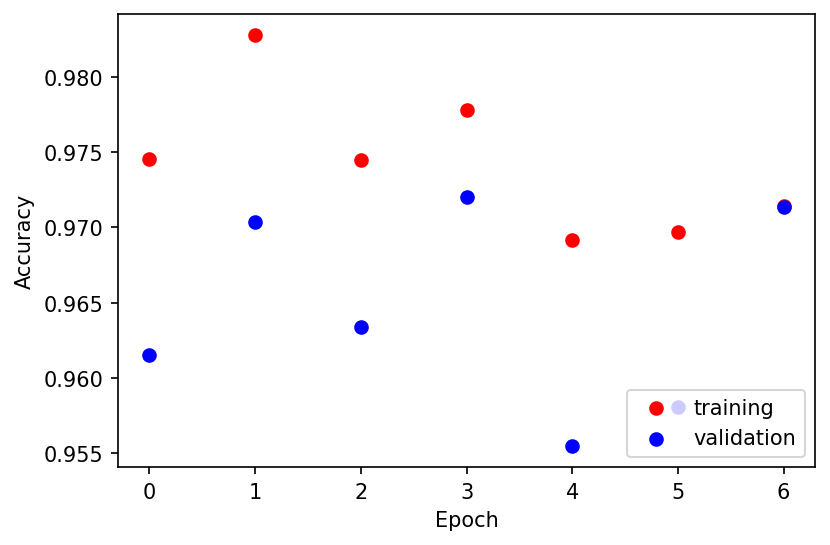

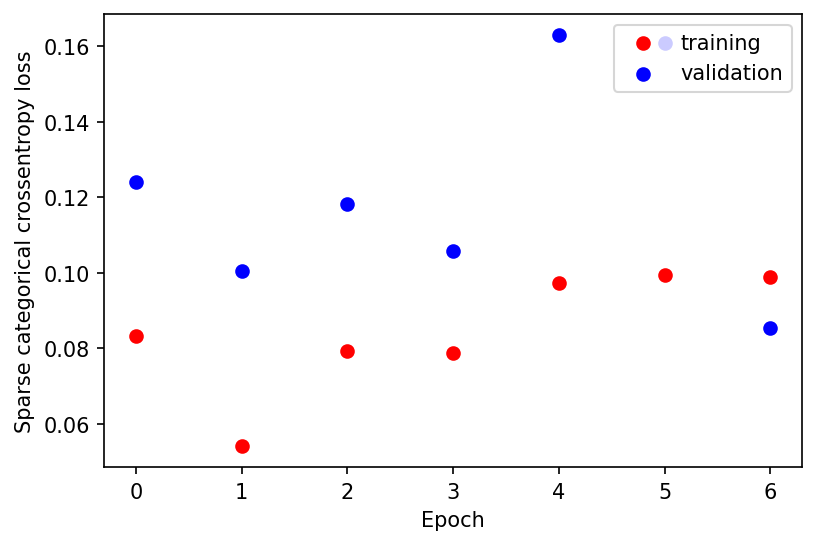

In [12]:
plt.figure(dpi=150)
plt.scatter(epochs,history['accuracy'], color = 'red', label = 'training')
plt.scatter(epochs,history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend(loc=4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig(r'RESULTS/results_figures/' + model_name + '_accuracies.png', bbox_inches='tight')

plt.figure(dpi=150)
plt.scatter(epochs,history['SparseCatCrossentropy'], color = 'red', label = 'training')
plt.scatter(epochs,history['val_SparseCatCrossentropy'],color = 'blue', label = 'validation')
plt.legend(loc=1)
plt.xlabel('Epoch')
plt.ylabel('Sparse categorical crossentropy loss')
# plt.savefig(r'RESULTS/results_figures/'+ model_name + '_sparse_cat_losses.png', bbox_inches='tight')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, 227, 3)            12        
                                                                 
 S2 (AveragePooling1D)       (None, 113, 3)            0         
                                                                 
 C3 (Conv1D)                 (None, 111, 3)            30        
                                                                 
 S4 (AveragePooling1D)       (None, 55, 3)             0         
                                                                 
 C5 (Conv1D)                 (None, 53, 3)             30        
                                                                 
 flatten (Flatten)           (None, 159)               0         
                                                                 
 dense (Dense)               (None, 275)               4

(255,)


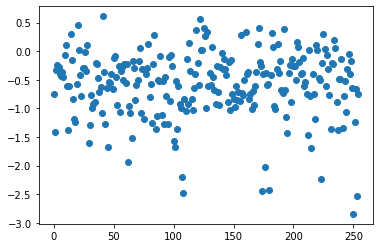

In [14]:
# Analyze weights

print(model.get_weights()[9].shape)

plt.scatter(range(255),model.get_weights()[9])

(275, 255)


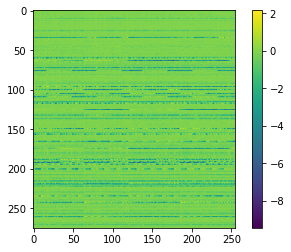

In [15]:
print(model.get_weights()[8].shape)

plt.imshow(model.get_weights()[8])
plt.colorbar()



(275,)


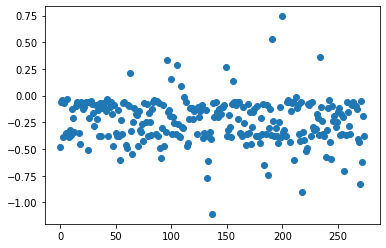

In [16]:
print(model.get_weights()[7].shape)

plt.scatter(range(model.get_weights()[7].shape[0]),model.get_weights()[7])

(159, 275)


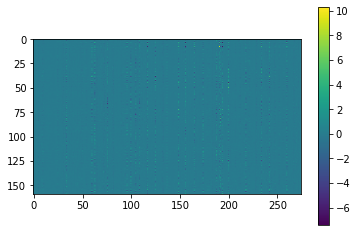

In [17]:
print(model.get_weights()[6].shape)

plt.imshow(model.get_weights()[6])
plt.colorbar()


(3,)


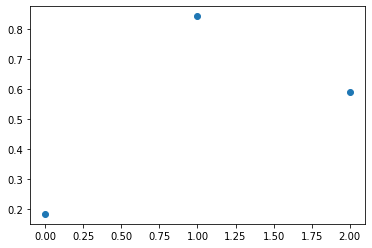

In [18]:
print(model.get_weights()[5].shape)

plt.scatter(range(model.get_weights()[5].shape[0]),model.get_weights()[5])

(3, 3, 3)


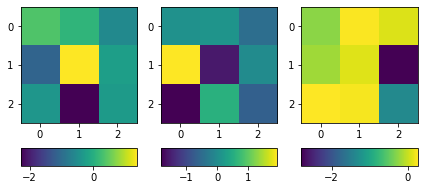

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(model.get_weights()[4].shape)

fig, ax = plt.subplots(1,3)

img1 = ax[0].imshow(model.get_weights()[4][0])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img1, cax=cax, orientation='horizontal')

img2=ax[1].imshow(model.get_weights()[4][1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img2, cax=cax, orientation='horizontal')

img3=ax[2].imshow(model.get_weights()[4][2])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img3, cax=cax, orientation='horizontal')

fig.tight_layout()

(3,)


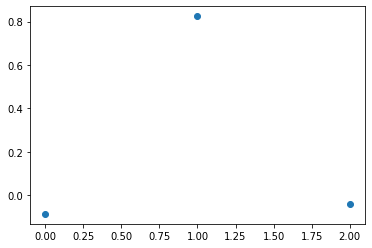

In [20]:
print(model.get_weights()[3].shape)

plt.scatter(range(model.get_weights()[3].shape[0]),model.get_weights()[3])

(3, 3, 3)


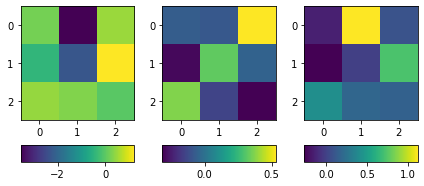

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(model.get_weights()[2].shape)

fig, ax = plt.subplots(1,3)

img1 = ax[0].imshow(model.get_weights()[2][0])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img1, cax=cax, orientation='horizontal')

img2=ax[1].imshow(model.get_weights()[2][1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img2, cax=cax, orientation='horizontal')

img3=ax[2].imshow(model.get_weights()[2][2])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img3, cax=cax, orientation='horizontal')

fig.tight_layout()

(3,)


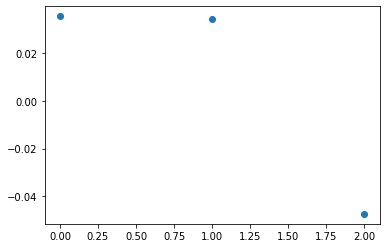

In [22]:
print(model.get_weights()[1].shape)

plt.scatter(range(model.get_weights()[1].shape[0]),model.get_weights()[1])

(3, 1, 3)


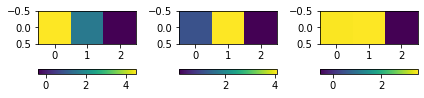

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(model.get_weights()[0].shape)

fig, ax = plt.subplots(1,3)

img1 = ax[0].imshow(model.get_weights()[0][0])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img1, cax=cax, orientation='horizontal')

img2=ax[1].imshow(model.get_weights()[0][1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img2, cax=cax, orientation='horizontal')

img3=ax[2].imshow(model.get_weights()[0][2])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('bottom', size='15%', pad=0.35)
fig.colorbar(img3, cax=cax, orientation='horizontal')

fig.tight_layout()

In [24]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_val)
pred_y=np.argmax(model.predict(x_val), axis=-1)


287/287 [==============================] - 1s 3ms/step


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, 227, 3)            12        
                                                                 
 S2 (AveragePooling1D)       (None, 113, 3)            0         
                                                                 
 C3 (Conv1D)                 (None, 111, 3)            30        
                                                                 
 S4 (AveragePooling1D)       (None, 55, 3)             0         
                                                                 
 C5 (Conv1D)                 (None, 53, 3)             30        
                                                                 
 flatten (Flatten)           (None, 159)               0         
                                                                 
 dense (Dense)               (None, 275)               4

# GradCAM

In [26]:
# layer_name = 'C3'
# #calculate max heatmap value to normalize the plots
# max_heat_map_vals=[]
# min_heat_map_vals=[]
# for i in x_val:
    
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data, model)
#     max_heat_map_vals.append(np.max(heatmap))
#     min_heat_map_vals.append(np.min(heatmap))

# print(f'layer {layer_name} class activation maps')

# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'bold',
#         'size': 16,
#         }

# freq_GHz = 29.9792458*m.frequencies

# count = 0





# for i,j,k in zip(x_val,y_val,pred_y):
    
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data, model)

    
    
#     # raw map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
#     plt.clim(np.min(heatmap),np.max(heatmap))
#     plt.show()
    
    
#     fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C3_val' + str(count) + '.png', bbox_inches='tight')
#     count = count + 1
    
#     if count ==10:
#         break
        
        

In [26]:
from sklearn.preprocessing import normalize

5,8,13,20,27,31,37,77,89,97,98,114,124,125,141,147,154,166,168,192,205

In [28]:
layer_name = 'C5'
#calculate max heatmap value to normalize the plots
# max_heat_map_vals=[]
# min_heat_map_vals=[]
# for i in x_val:
    
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data, model)
#     max_heat_map_vals.append(np.max(heatmap))
#     min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies


count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
#     heatmap = normalize(grad_cam(layer_name,data, model), axis=0)
    normalized_hm = [(x-np.min(heatmap[0]))/(np.max(heatmap[0])-np.min(heatmap[0])) for x in heatmap[0]]
    heatmap = np.expand_dims(normalized_hm,0)
#     import pdb; pdb.set_trace()
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    plt.rc('font', weight='bold')
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='inferno', aspect="auto", 
               interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Absorbance')
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.close()
#     plt.show()
    
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C5_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==210:
        break
        
        

layer C5 class activation maps


layer C5 class activation maps


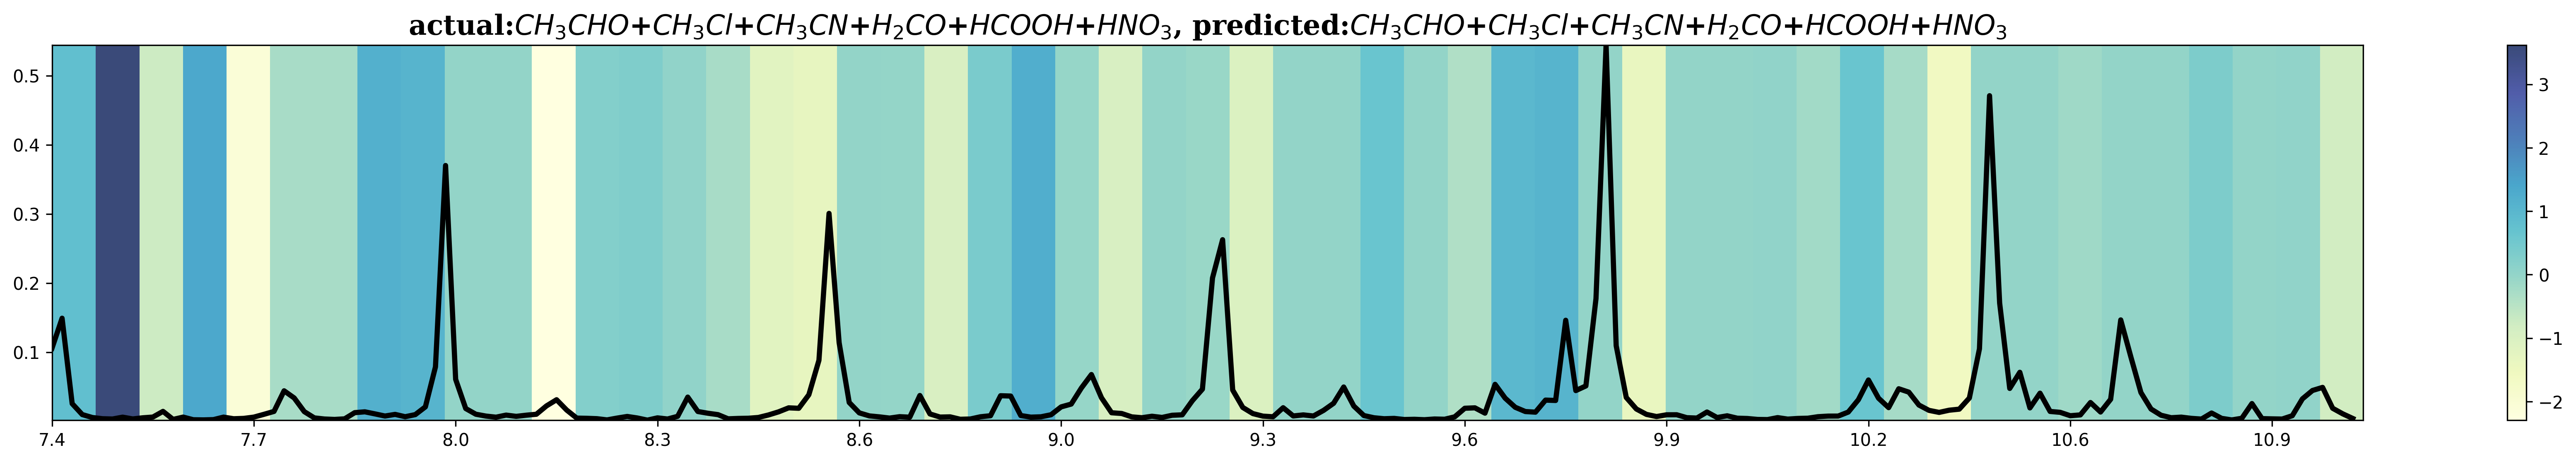

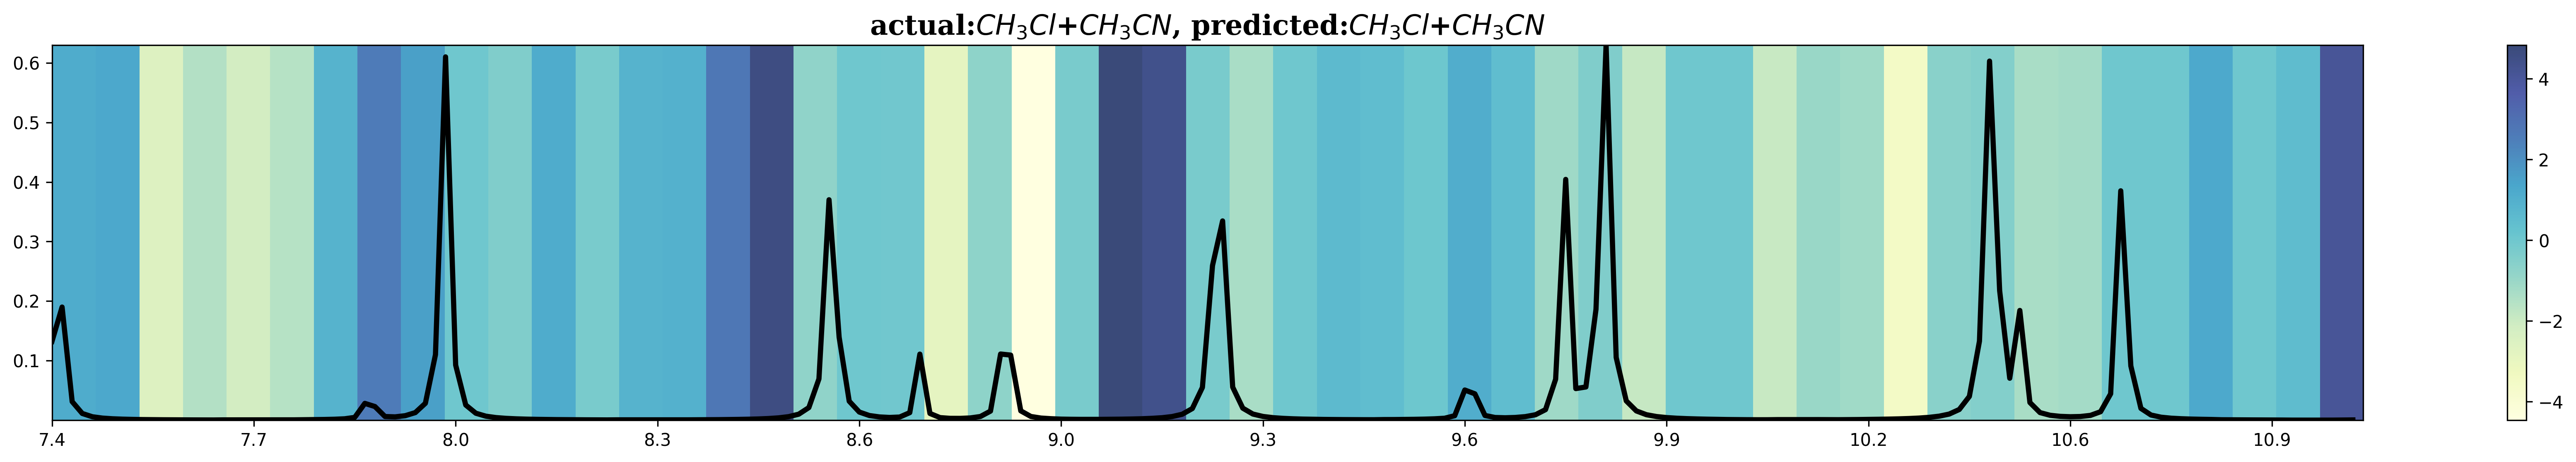

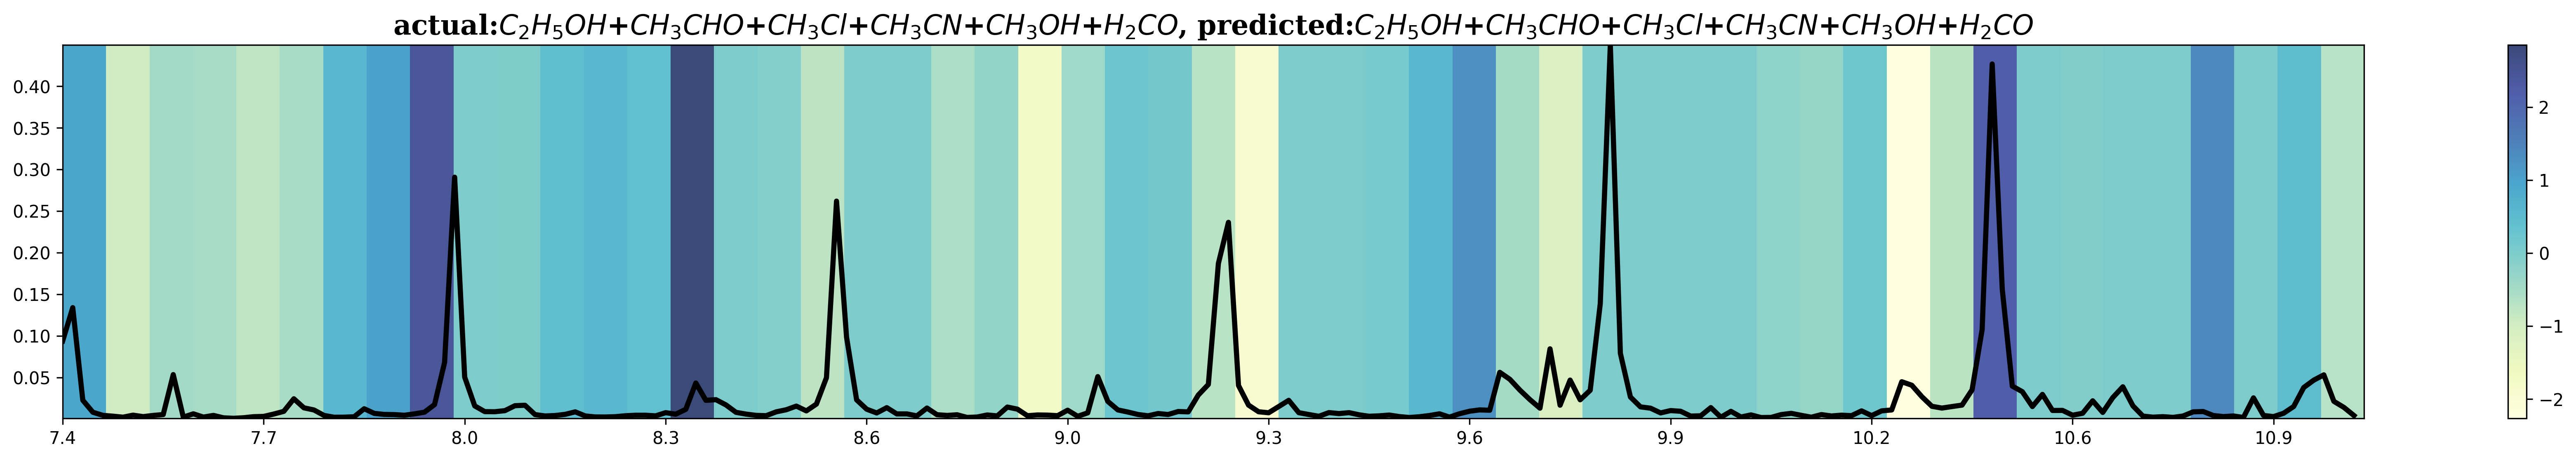

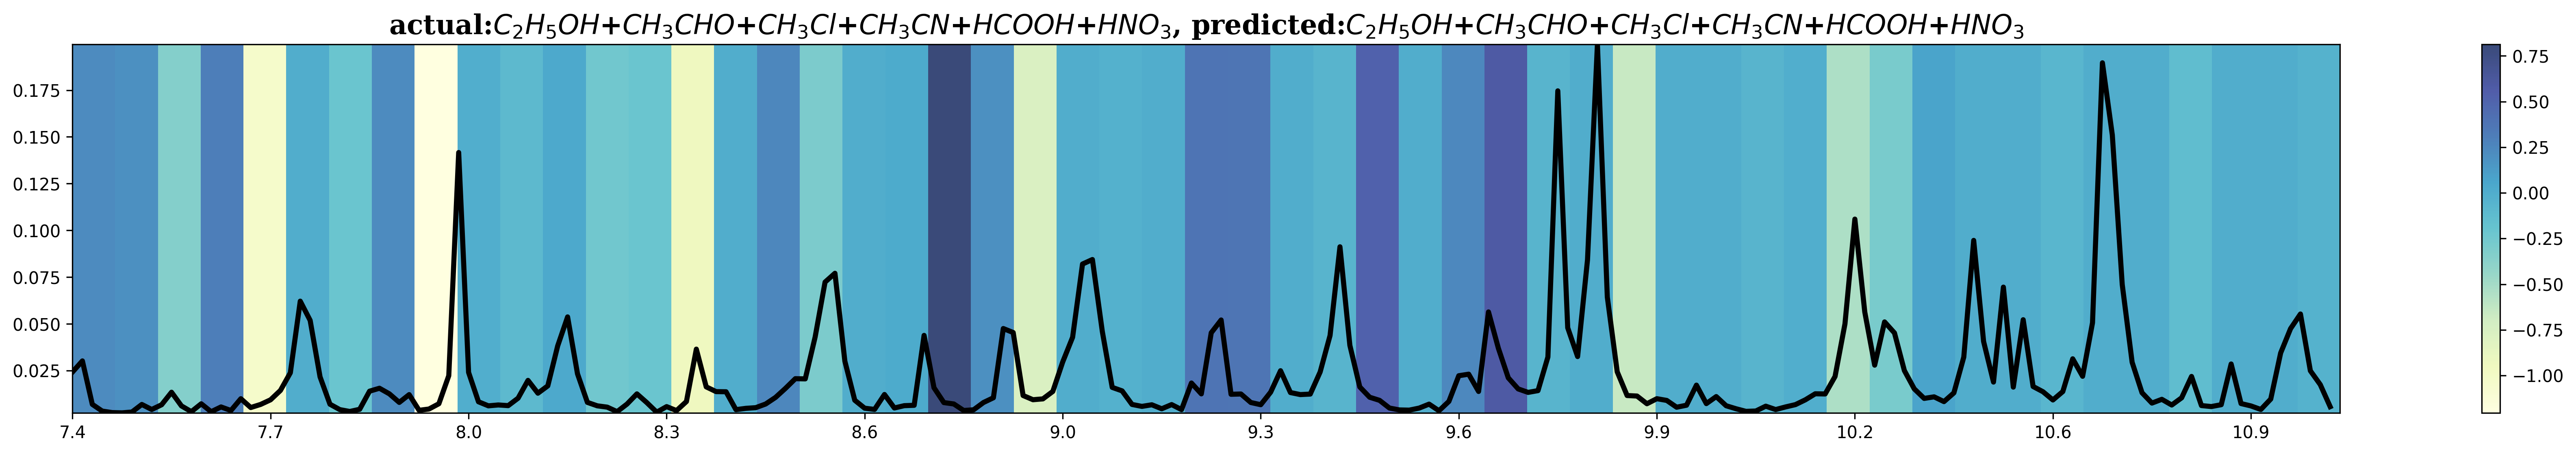

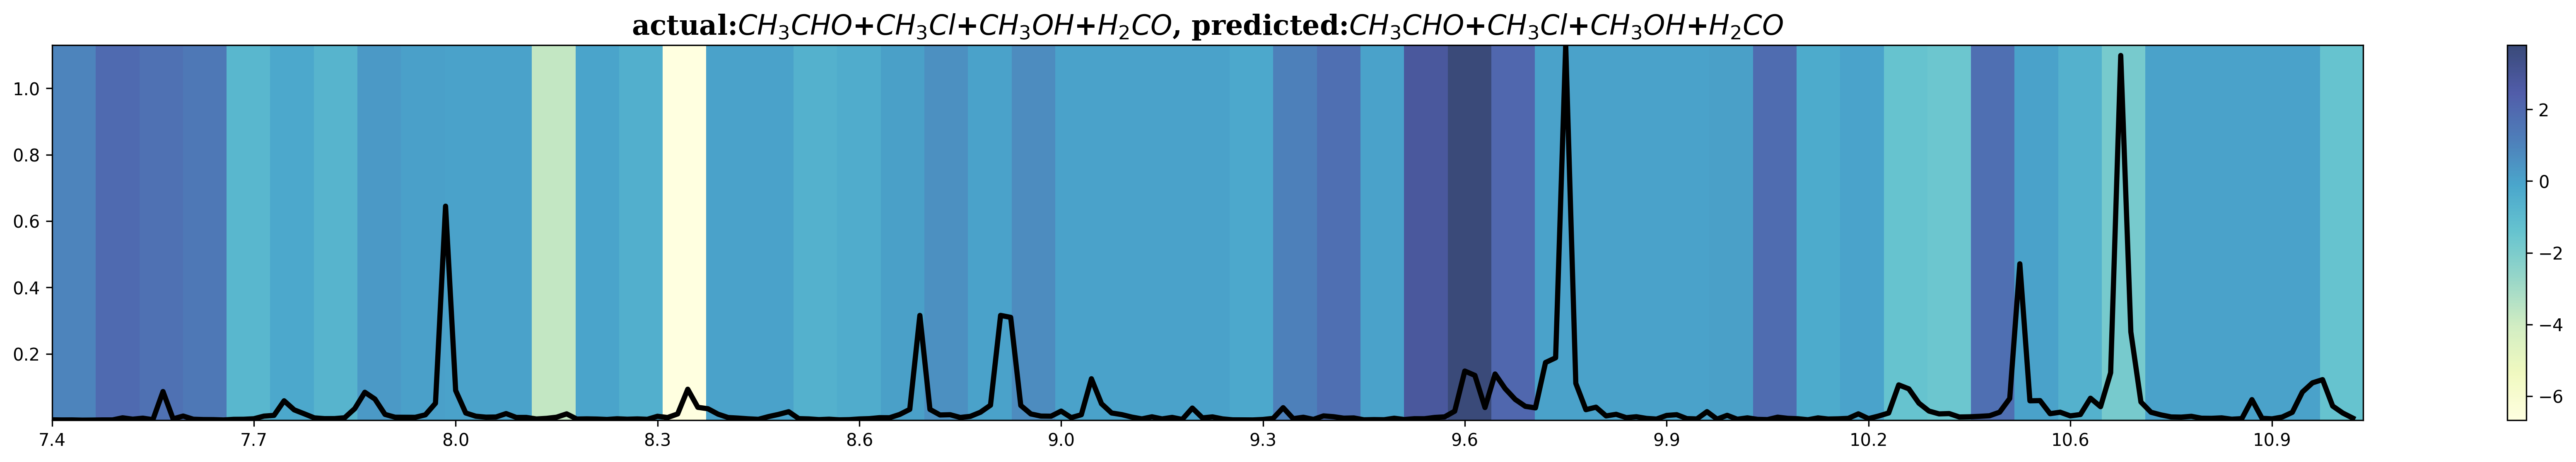

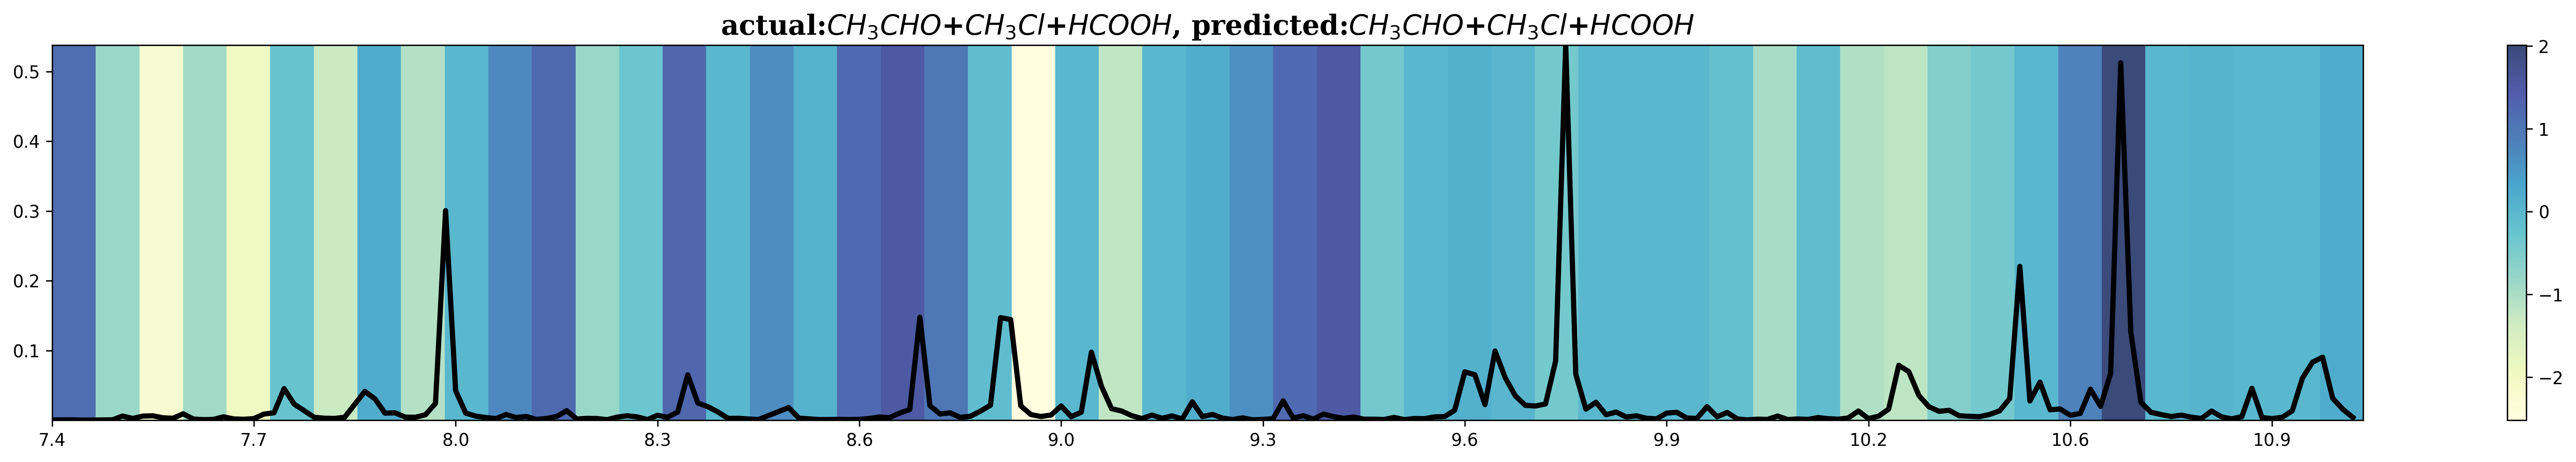

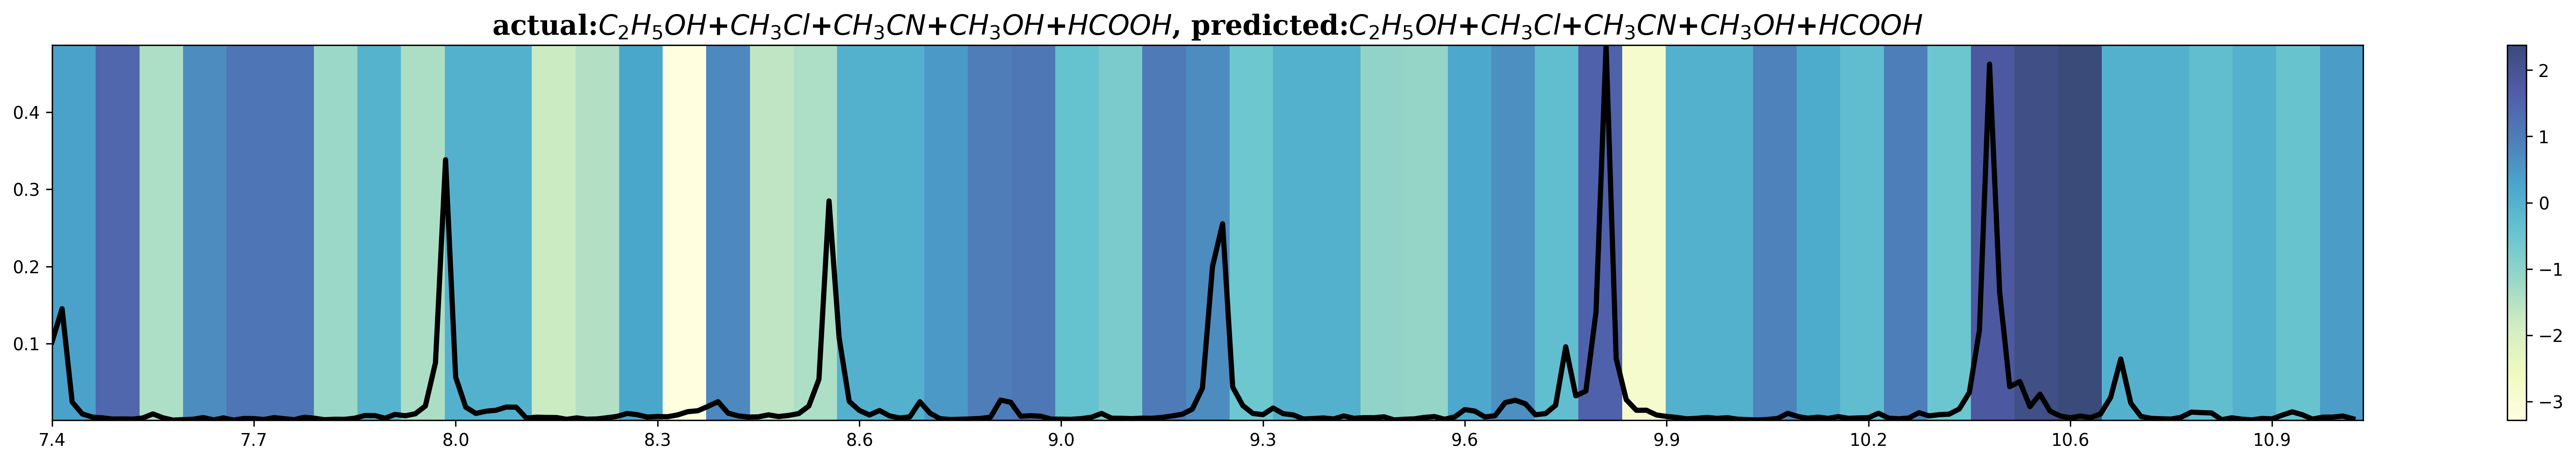

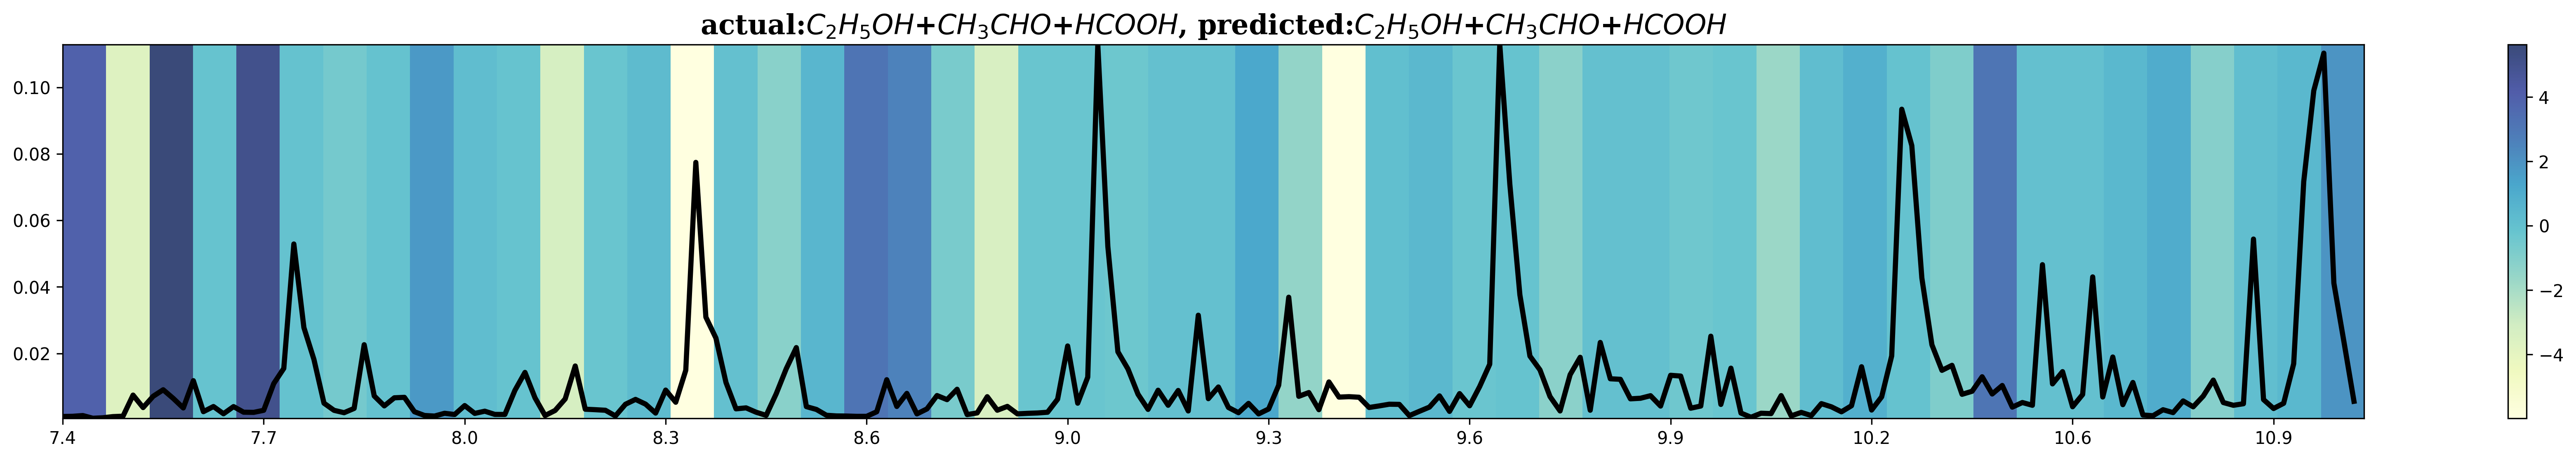

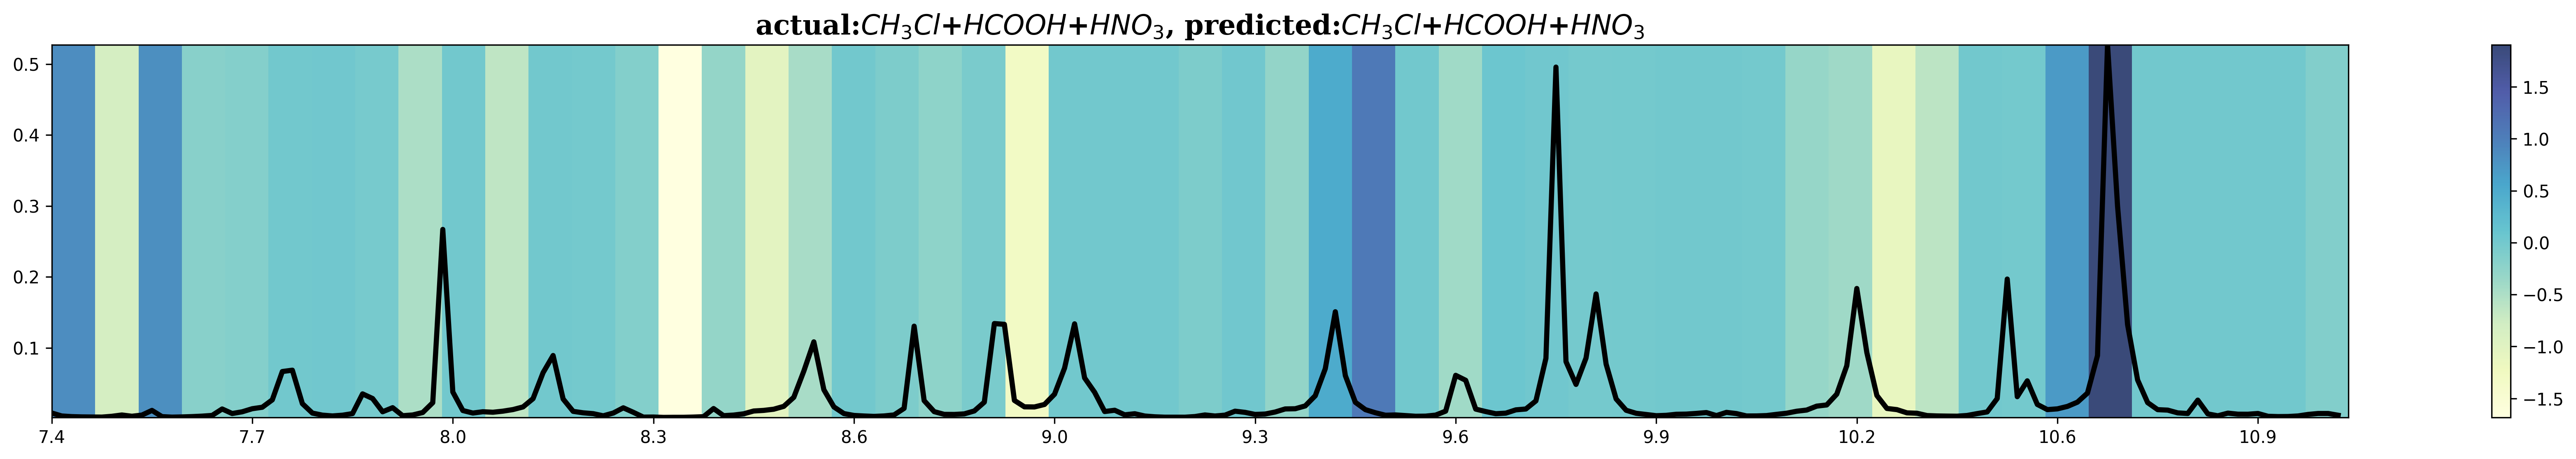

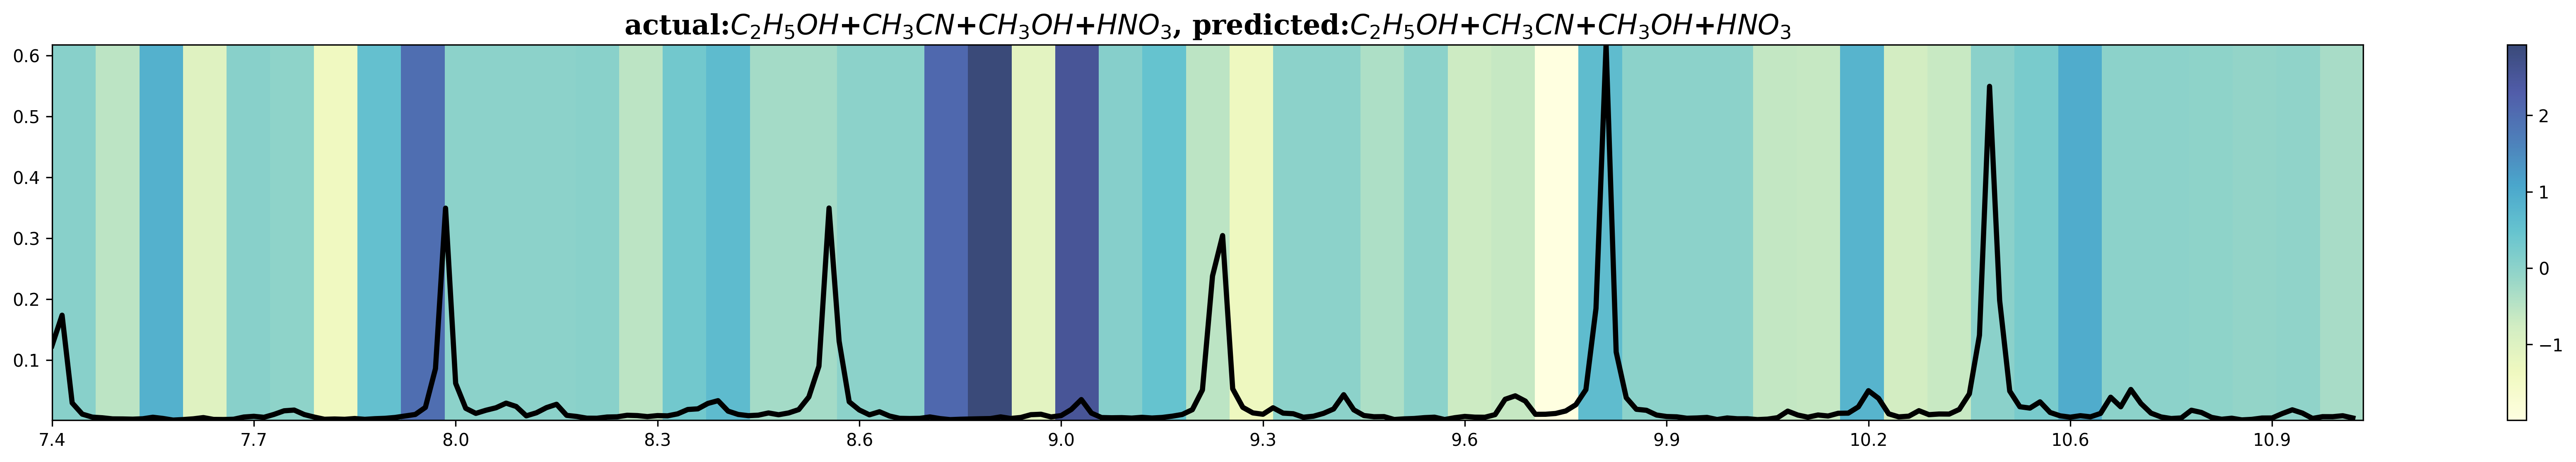

In [27]:
layer_name = 'C5'
#calculate max heatmap value to normalize the plots
max_heat_map_vals=[]
min_heat_map_vals=[]
for i in x_val:
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    max_heat_map_vals.append(np.max(heatmap))
    min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

# freq_GHz = 29.9792458*m.frequencies
freq_GHz = m.frequencies

count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
#     heatmap = normalize(grad_cam(layer_name,data, model), axis=0)
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
    
    
#     fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C5_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==10:
        break
        
        

In [ ]:
exps = ['1 comp/v2Paper Ethanol 1 Torr.csv',
       '1 comp/Methanol 1 Torr WDL 8.csv',
       '1 comp/Formic Acid 1 Torr WDL 5 Notch Shift.csv',
       '1 comp/Acetaldehyde 1 Torr WDL 6 Notch.csv',
       '1 comp/Acetaldehyde 0p5 Torr WDL 5.csv',
       '1 comp/1-Sweep v2 CH3OH 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-0p5 Torr.csv',
       '1 comp/1-Sweep 0p5 Torr-CH3CN.csv',]
true_label=[120,112,248,0,0,80,80,64]

In [36]:


exps = ['1 comp/v2Paper Ethanol 1 Torr.csv',
       '1 comp/Methanol 1 Torr WDL 8.csv',
       '1 comp/Formic Acid 1 Torr WDL 5 Notch Shift.csv',
       '1 comp/Acetaldehyde 1 Torr WDL 6 Notch.csv',
       '1 comp/Acetaldehyde 0p5 Torr WDL 5.csv',
       '1 comp/1-Sweep v2 CH3OH 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-0p5 Torr.csv',
       '1 comp/1-Sweep 0p5 Torr-CH3CN.csv',
        '2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/90% Dilute in N2 - 0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN.xlsx'       ]

true_label=[120,112,248,0,0,112, 80,80,64,81,81,81,82,82,19,19]

exp_path = '../../data/Mixture_exp_data/'
exp_filepath = '4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx'


def classify_exp(exp_path,exp_filepath,mixture_types,true_label, excel=True):
    all_unique_labels= mixture_types
    if excel:
        df_exp1 = pd.read_excel(exp_path + exp_filepath)
    else:
        df_exp1 = pd.read_csv(exp_path + exp_filepath)


    freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
    abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()
    
#     fft_filter(freq_exp1, abs_exp1, factor=75)

    dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
    dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
    expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
    pred_exp_label = np.argmax(model.predict(expanded_abs), axis=-1)[0]
    
    score_predictions = probability_model.predict(expanded_abs)
    scoreDf = pd.DataFrame()
    scoreDf['mixture_type'] = mixture_types
#     import pdb; pdb.set_trace()
    scoreDf['softmax'] = score_predictions[0]
#     scoreDf.to_csv(r'RESULTS/exp_preds/' + 'exp' + str(idx) + '.csv')
    
    sorted_scoresDf = scoreDf.sort_values(by='softmax', ascending=False).head(n=5)
    
#     print(score_predictions)
    print('Experiment name: ',exp_filepath.split('/')[0])
    print('File name: ',exp_filepath.split('/')[1])
    print('predicted index ', pred_exp_label)
    print('predicted label', mixture_types[pred_exp_label])

    return dfy_resampled,pred_exp_label, sorted_scoresDf




idx = 0 
Xexp = []
pred_exp = []
for experiment in exps:
    if idx<9:
        dfy_resampled, pred_exp_label, sorted_scoresDf = classify_exp(exp_path,experiment,mixture_types, true_label[idx],excel=False)
    else:
        dfy_resampled, pred_exp_label, sorted_scoresDf = classify_exp(exp_path,experiment,mixture_types, true_label[idx],excel=True)
    idx+=1
    Xexp.append(dfy_resampled)
    pred_exp.append(pred_exp_label)
    sorted_scoresDf.index.name = 'label'


Experiment name:  1 comp
File name:  v2Paper Ethanol 1 Torr.csv
predicted index  120
predicted label $C_2H_5OH$
Experiment name:  1 comp
File name:  Methanol 1 Torr WDL 8.csv
predicted index  112
predicted label $CH_3OH$
Experiment name:  1 comp
File name:  Formic Acid 1 Torr WDL 5 Notch Shift.csv
predicted index  248
predicted label $HCOOH$
Experiment name:  1 comp
File name:  Acetaldehyde 1 Torr WDL 6 Notch.csv
predicted index  122
predicted label $C_2H_5OH$+$CH_3CHO$+$CH_3CN$
Experiment name:  1 comp
File name:  Acetaldehyde 0p5 Torr WDL 5.csv
predicted index  12
predicted label $CH_3CHO$+$CH_3CN$+$HNO_3$
Experiment name:  1 comp
File name:  1-Sweep v2 CH3OH 220-330-1 Torr.csv
predicted index  112
predicted label $CH_3OH$
Experiment name:  1 comp
File name:  1-Sweep CH3Cl 220-330-1 Torr.csv
predicted index  80
predicted label $CH_3Cl$
Experiment name:  1 comp
File name:  1-Sweep CH3Cl 220-330-0p5 Torr.csv
predicted index  80
predicted label $CH_3Cl$
Experiment name:  1 comp
File nam

In [36]:


exps = ['1 comp/v2Paper Ethanol 1 Torr.csv',
       '1 comp/Methanol 1 Torr WDL 8.csv',
       '1 comp/Formic Acid 1 Torr WDL 5 Notch Shift.csv',
       '1 comp/Acetaldehyde 1 Torr WDL 6 Notch.csv',
       '1 comp/Acetaldehyde 0p5 Torr WDL 5.csv',
       '1 comp/1-Sweep v2 CH3OH 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-1 Torr.csv',
       '1 comp/1-Sweep CH3Cl 220-330-0p5 Torr.csv',
       '1 comp/1-Sweep 0p5 Torr-CH3CN.csv',
        '2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/90% Dilute in N2 - 0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN.xlsx'       ]

true_label=[120,112,248,0,0,112, 80,80,64,81,81,81,82,82,19,19]

exp_path = '../../data/Mixture_exp_data/'
exp_filepath = '4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx'


def classify_exp(exp_path,exp_filepath,mixture_types,true_label, excel=True):
    all_unique_labels= mixture_types
    if excel:
        df_exp1 = pd.read_excel(exp_path + exp_filepath)
    else:
        df_exp1 = pd.read_csv(exp_path + exp_filepath)


    freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
    abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()
    
#     fft_filter(freq_exp1, abs_exp1, factor=75)

    dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
    dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
    expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
    pred_exp_label = np.argmax(model.predict(expanded_abs), axis=-1)[0]
    
    score_predictions = probability_model.predict(expanded_abs)
    scoreDf = pd.DataFrame()
    scoreDf['mixture_type'] = mixture_types
#     import pdb; pdb.set_trace()
    scoreDf['softmax'] = score_predictions[0]
#     scoreDf.to_csv(r'RESULTS/exp_preds/' + 'exp' + str(idx) + '.csv')
    
    sorted_scoresDf = scoreDf.sort_values(by='softmax', ascending=False).head(n=5)
    
#     print(score_predictions)
    print('Experiment name: ',exp_filepath.split('/')[0])
    print('File name: ',exp_filepath.split('/')[1])
    print('predicted index ', pred_exp_label)
    print('predicted label', mixture_types[pred_exp_label])

    return dfy_resampled,pred_exp_label, sorted_scoresDf




idx = 0 
Xexp = []
pred_exp = []
for experiment in exps:
    if idx<9:
        dfy_resampled, pred_exp_label, sorted_scoresDf = classify_exp(exp_path,experiment,mixture_types, true_label[idx],excel=False)
    else:
        dfy_resampled, pred_exp_label, sorted_scoresDf = classify_exp(exp_path,experiment,mixture_types, true_label[idx],excel=True)
    idx+=1
    Xexp.append(dfy_resampled)
    pred_exp.append(pred_exp_label)
    sorted_scoresDf.index.name = 'label'


1/1 [==============================] - 0s 40ms/step
Experiment name:  1 comp
File name:  v2Paper Ethanol 1 Torr.csv
predicted index  120
predicted label $C_2H_5OH$
1/1 [==============================] - 0s 31ms/step
Experiment name:  1 comp
File name:  Methanol 1 Torr WDL 8.csv
predicted index  112
predicted label $CH_3OH$
1/1 [==============================] - 0s 28ms/step
Experiment name:  1 comp
File name:  Formic Acid 1 Torr WDL 5 Notch Shift.csv
predicted index  248
predicted label $HCOOH$
1/1 [==============================] - 0s 25ms/step
Experiment name:  1 comp
File name:  Acetaldehyde 1 Torr WDL 6 Notch.csv
predicted index  122
predicted label $C_2H_5OH$+$CH_3CHO$+$CH_3CN$
1/1 [==============================] - 0s 29ms/step
Experiment name:  1 comp
File name:  Acetaldehyde 0p5 Torr WDL 5.csv
predicted index  12
predicted label $CH_3CHO$+$CH_3CN$+$HNO_3$
1/1 [==============================] - 0s 27ms/step
Experiment name:  1 comp
File name:  1-Sweep v2 CH3OH 220-330-1 Torr.csv

In [37]:
Xexp
yexp=true_label

layer C5 class activation maps


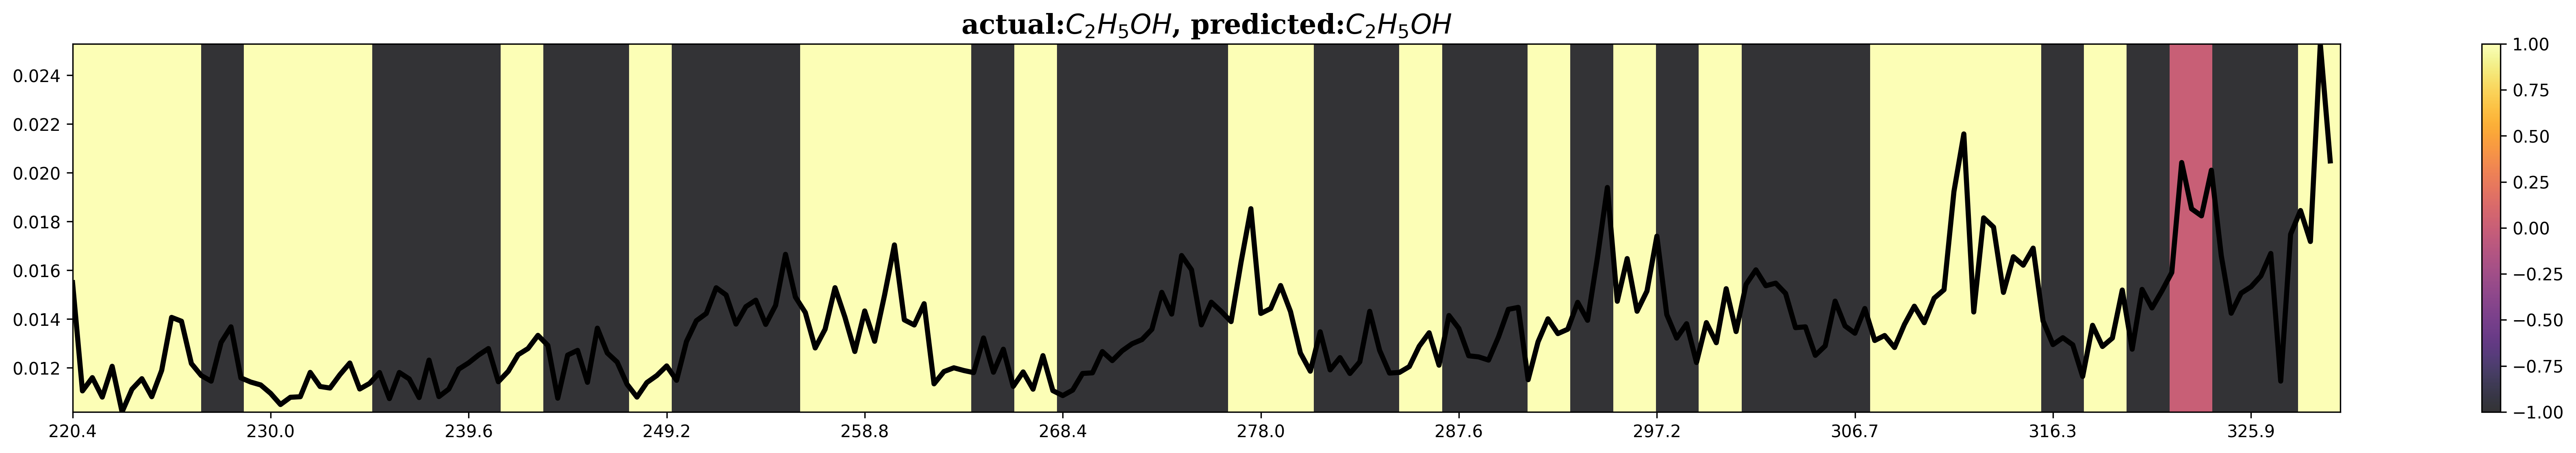

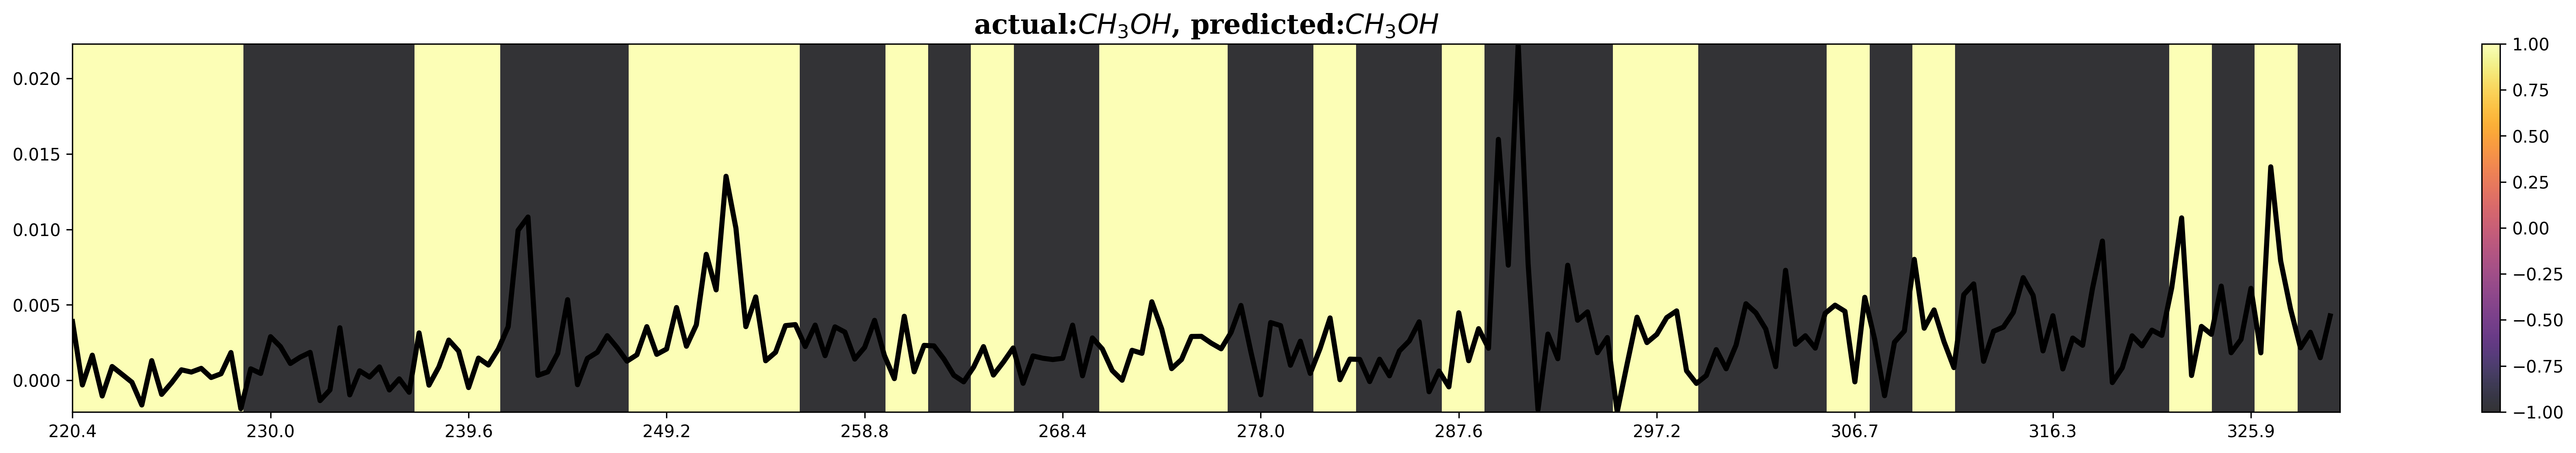

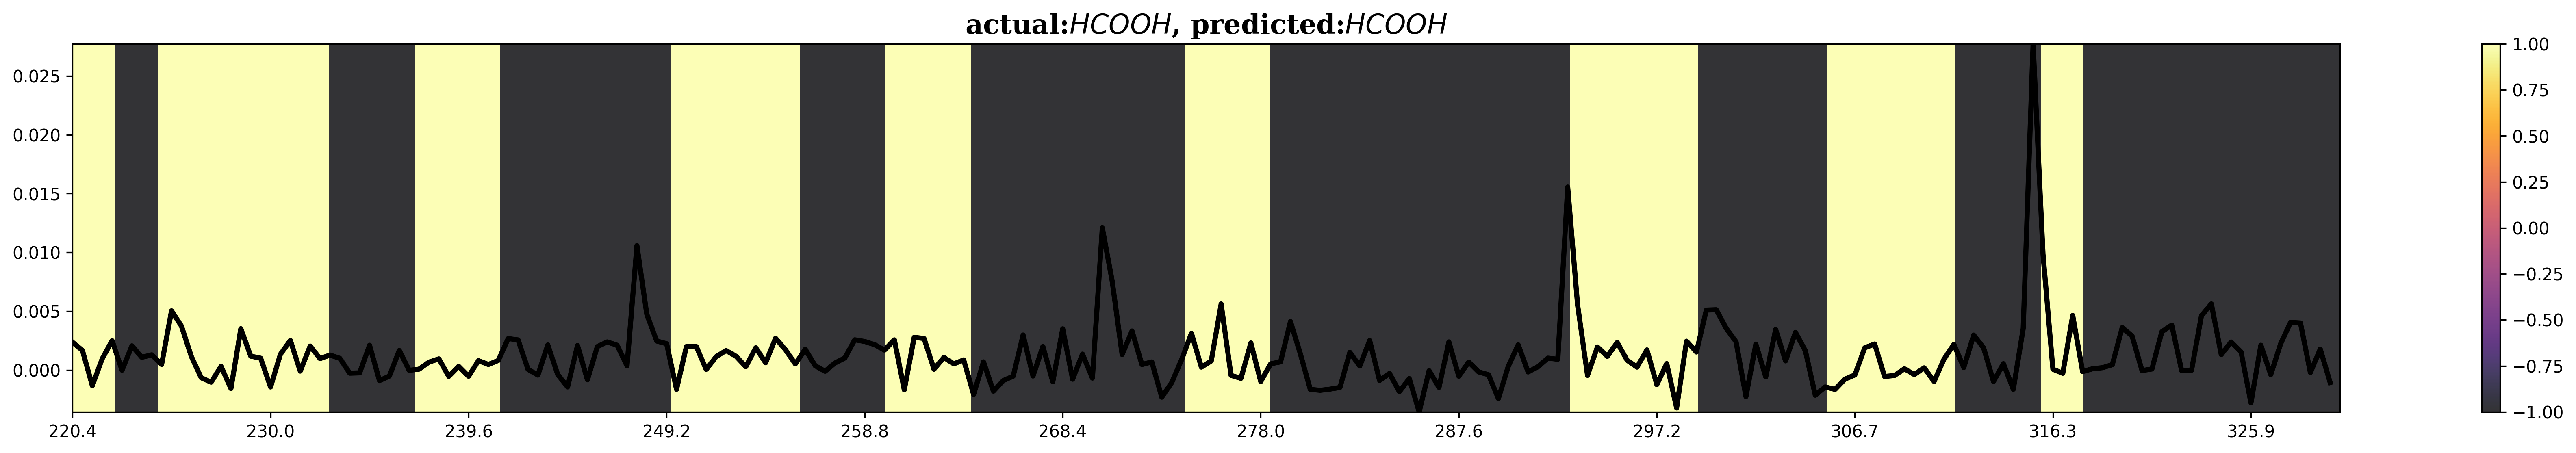

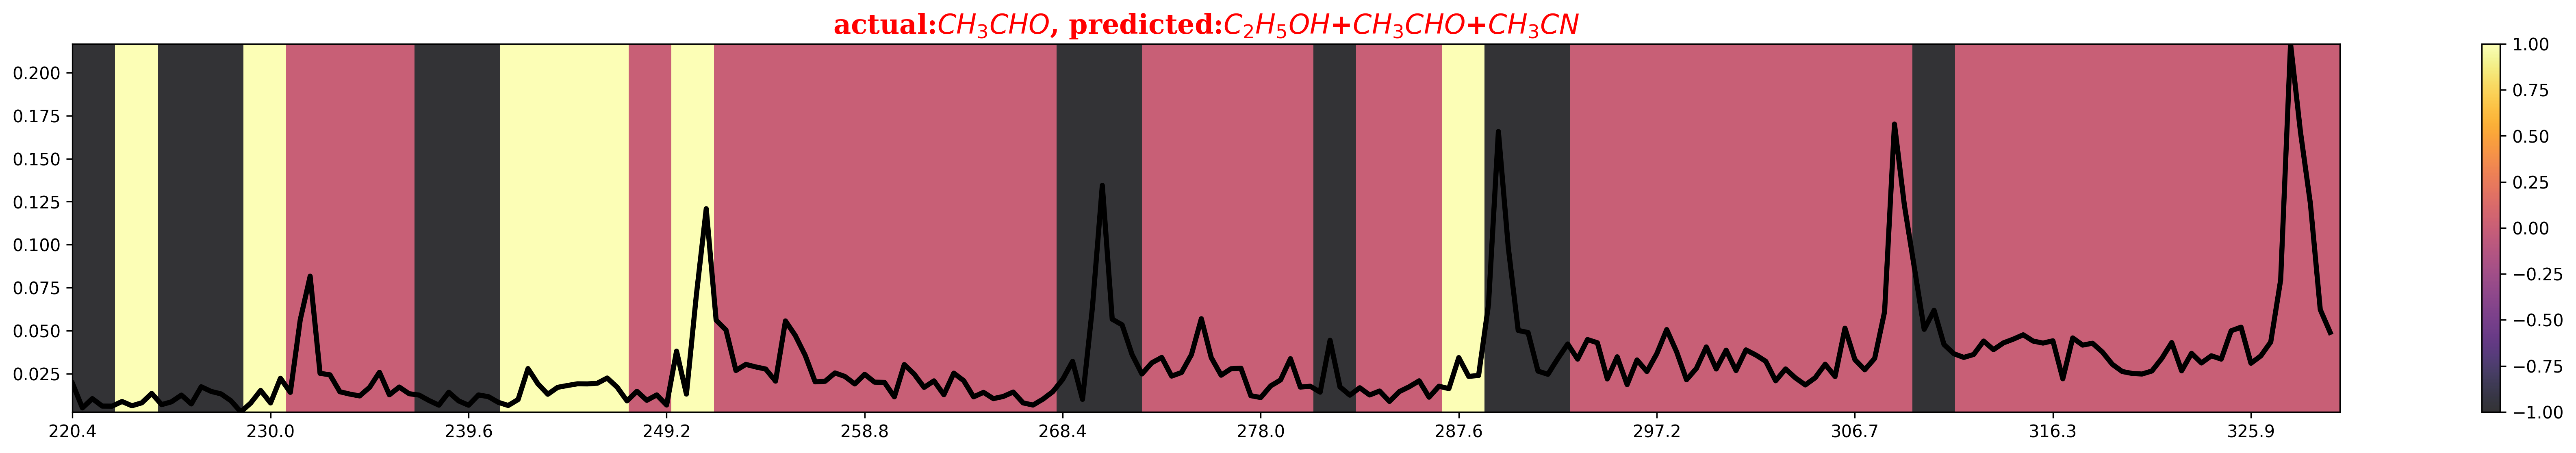

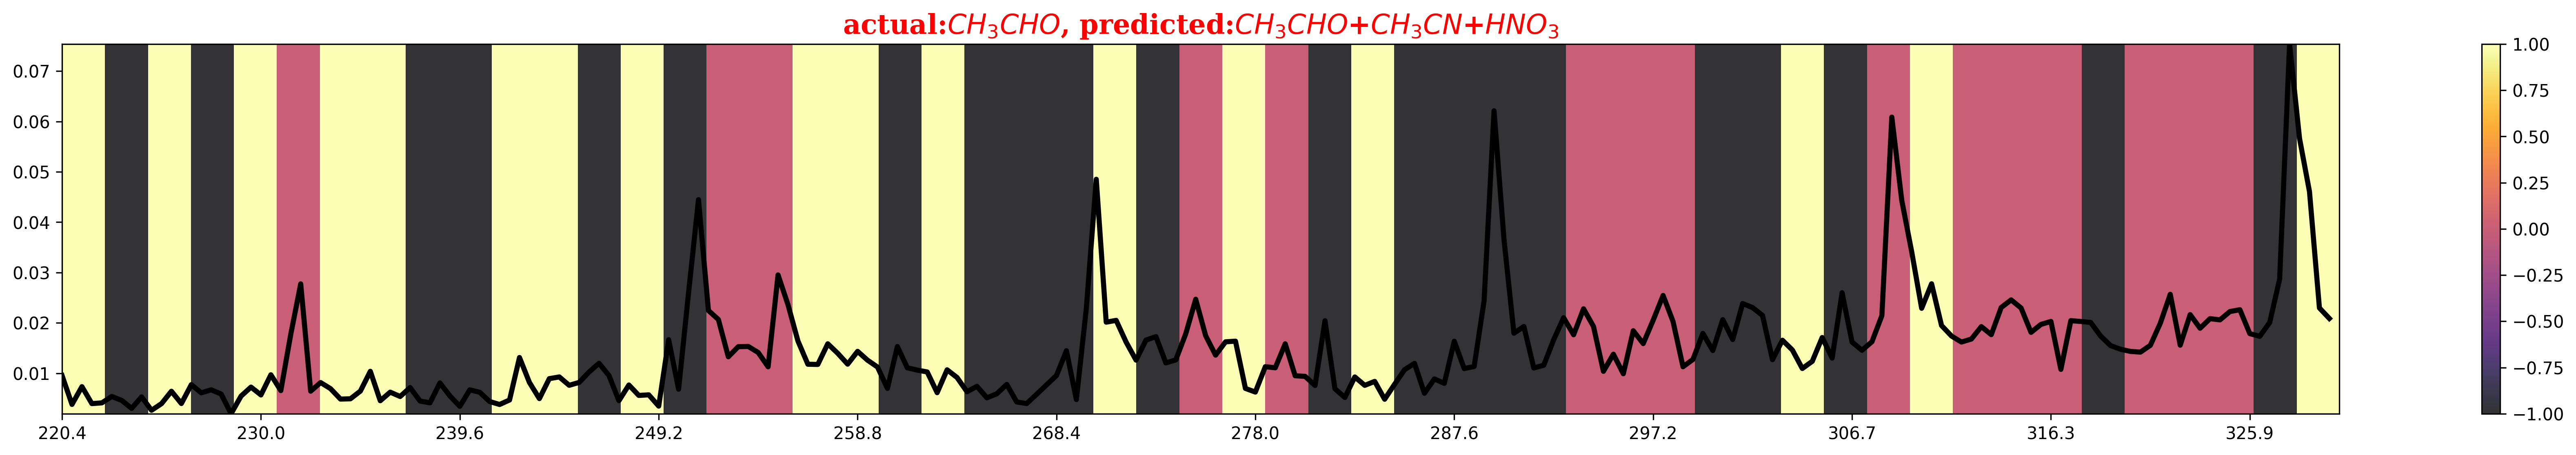

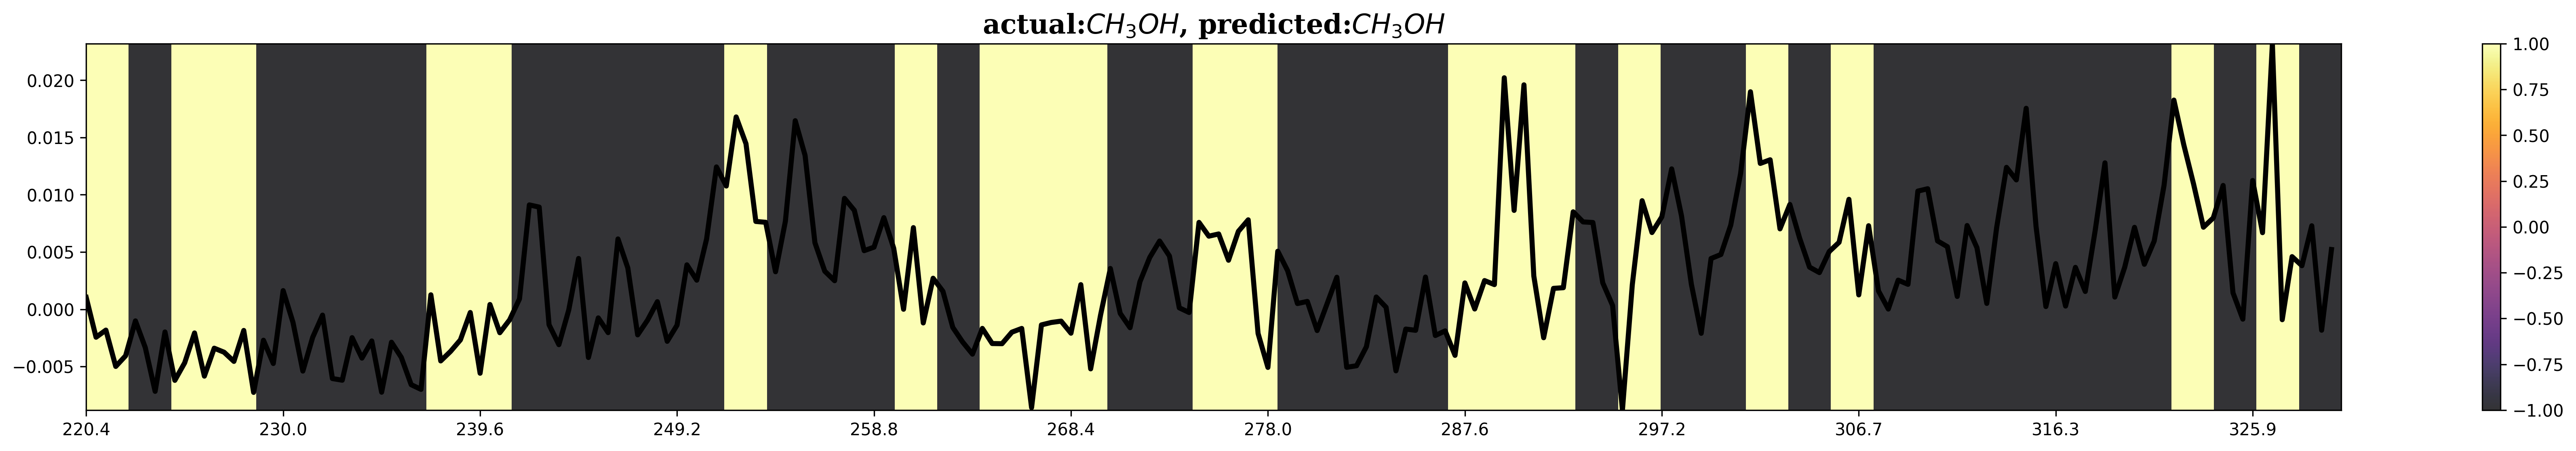

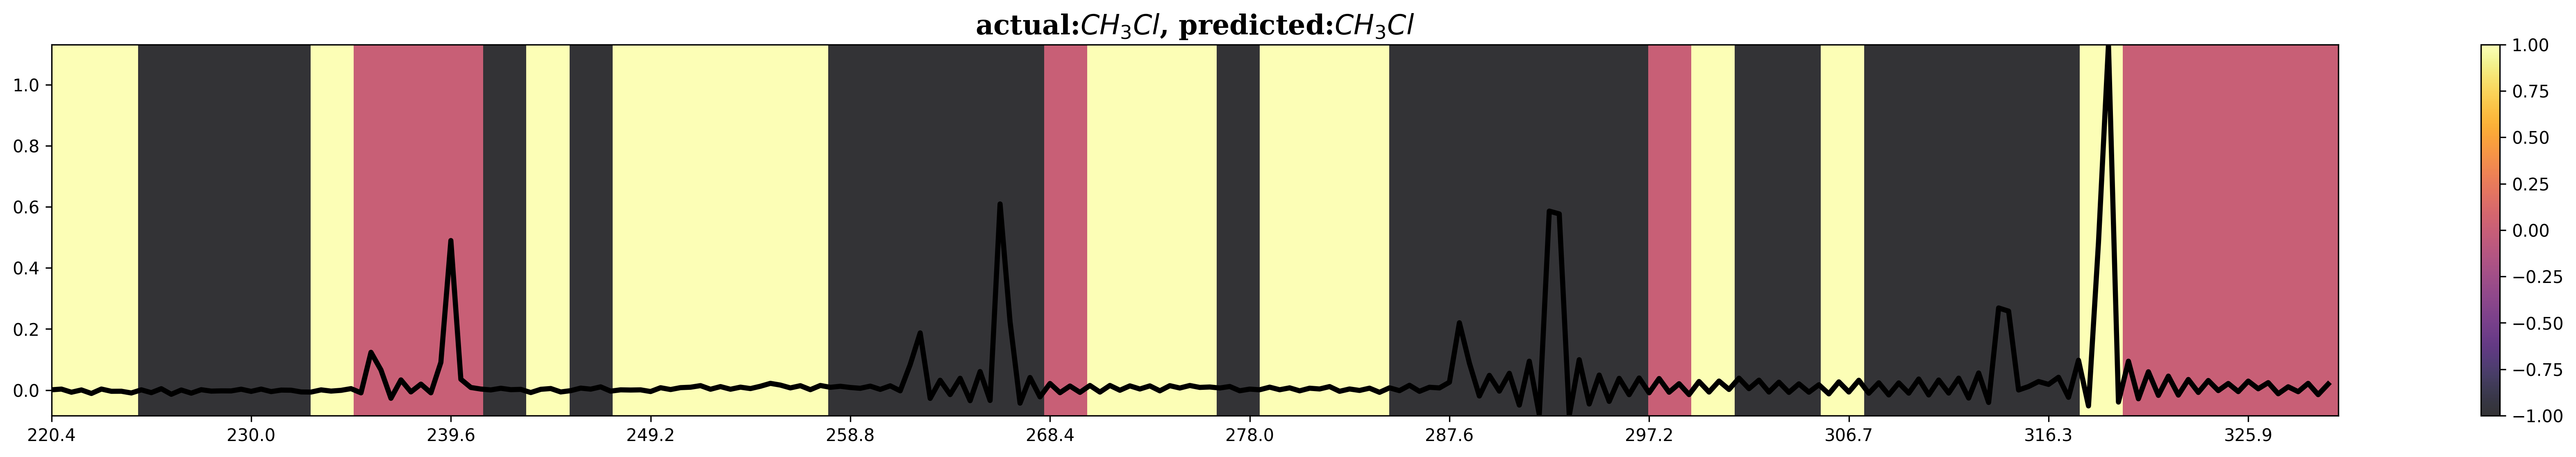

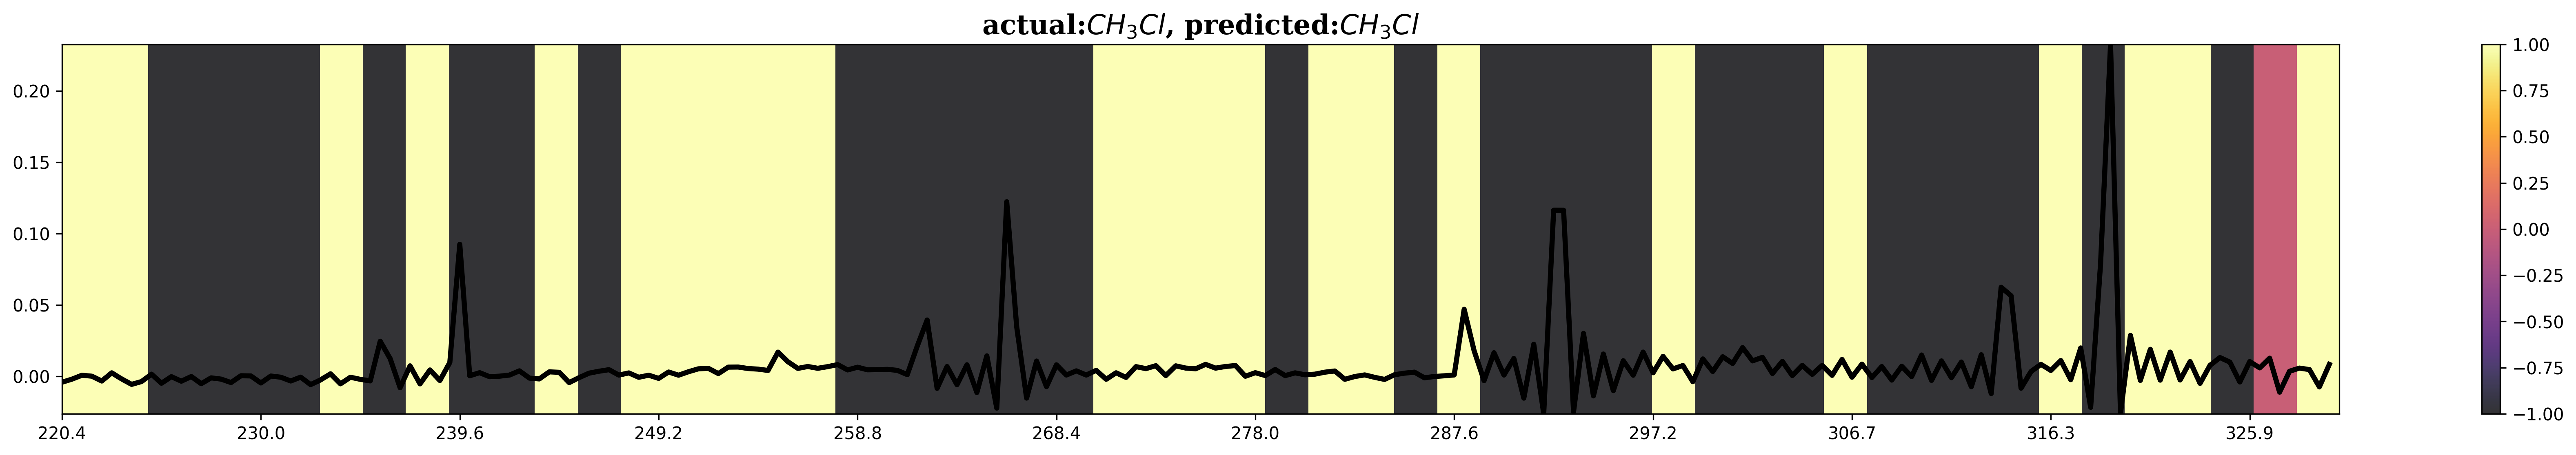

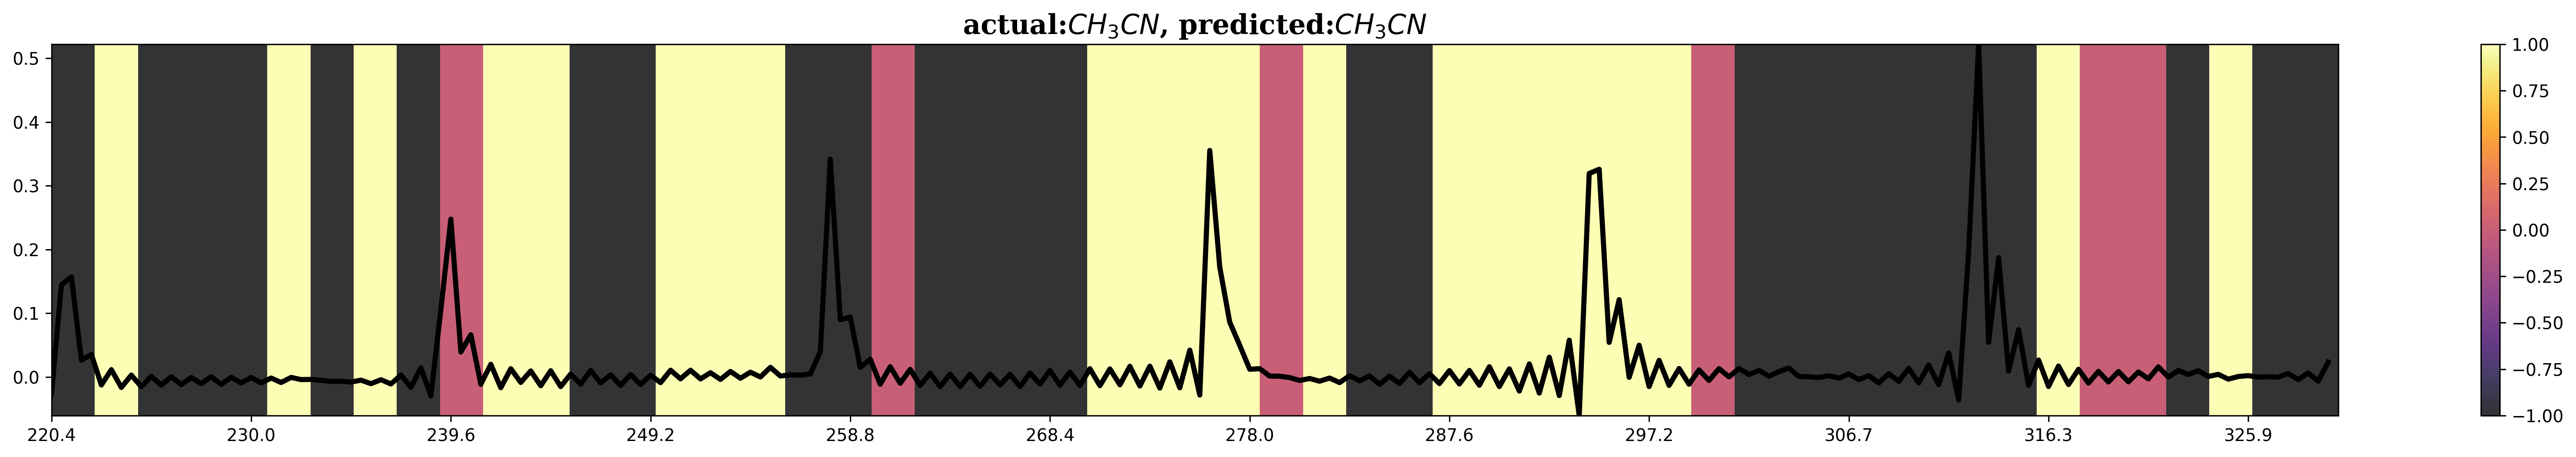

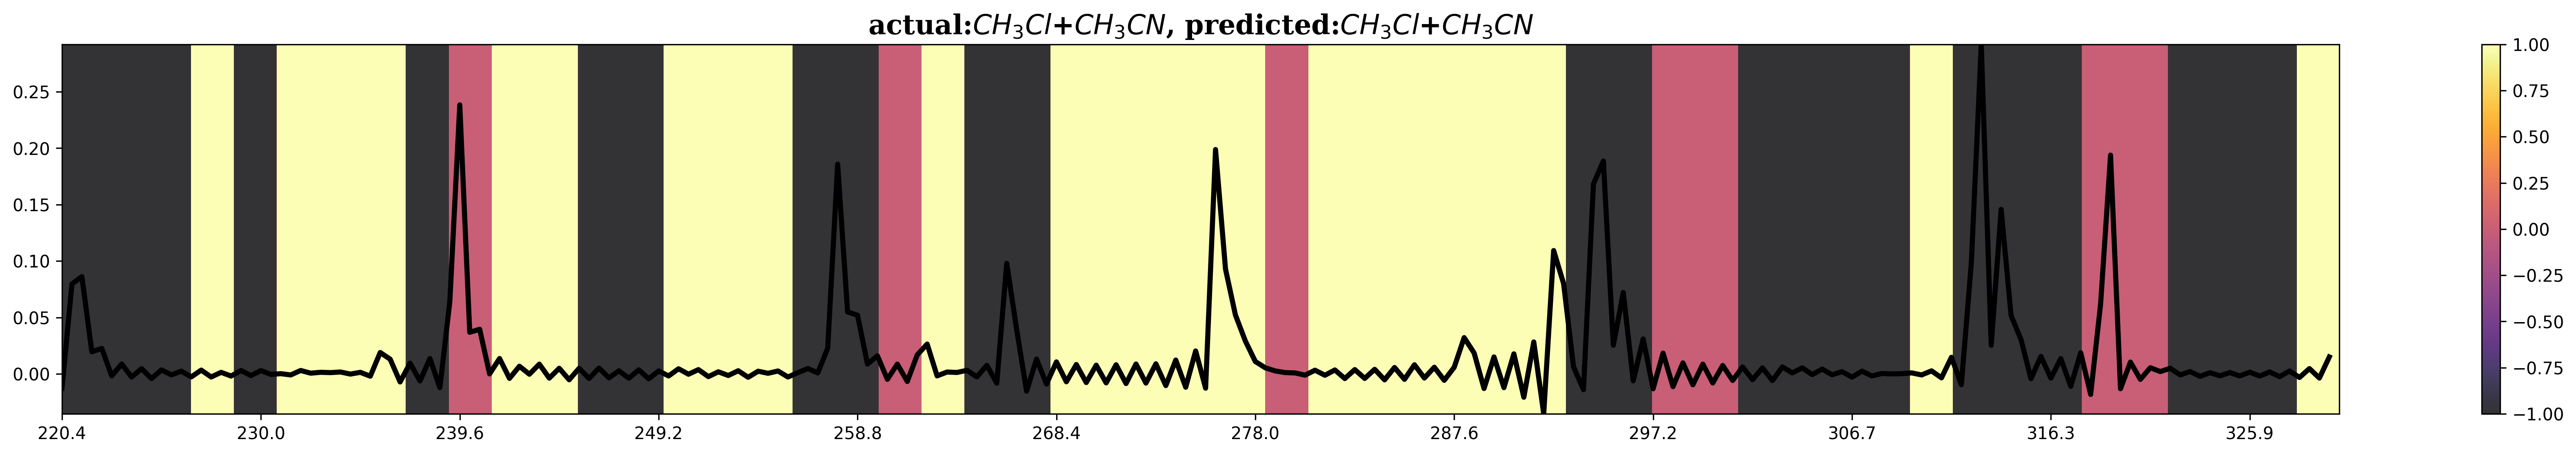

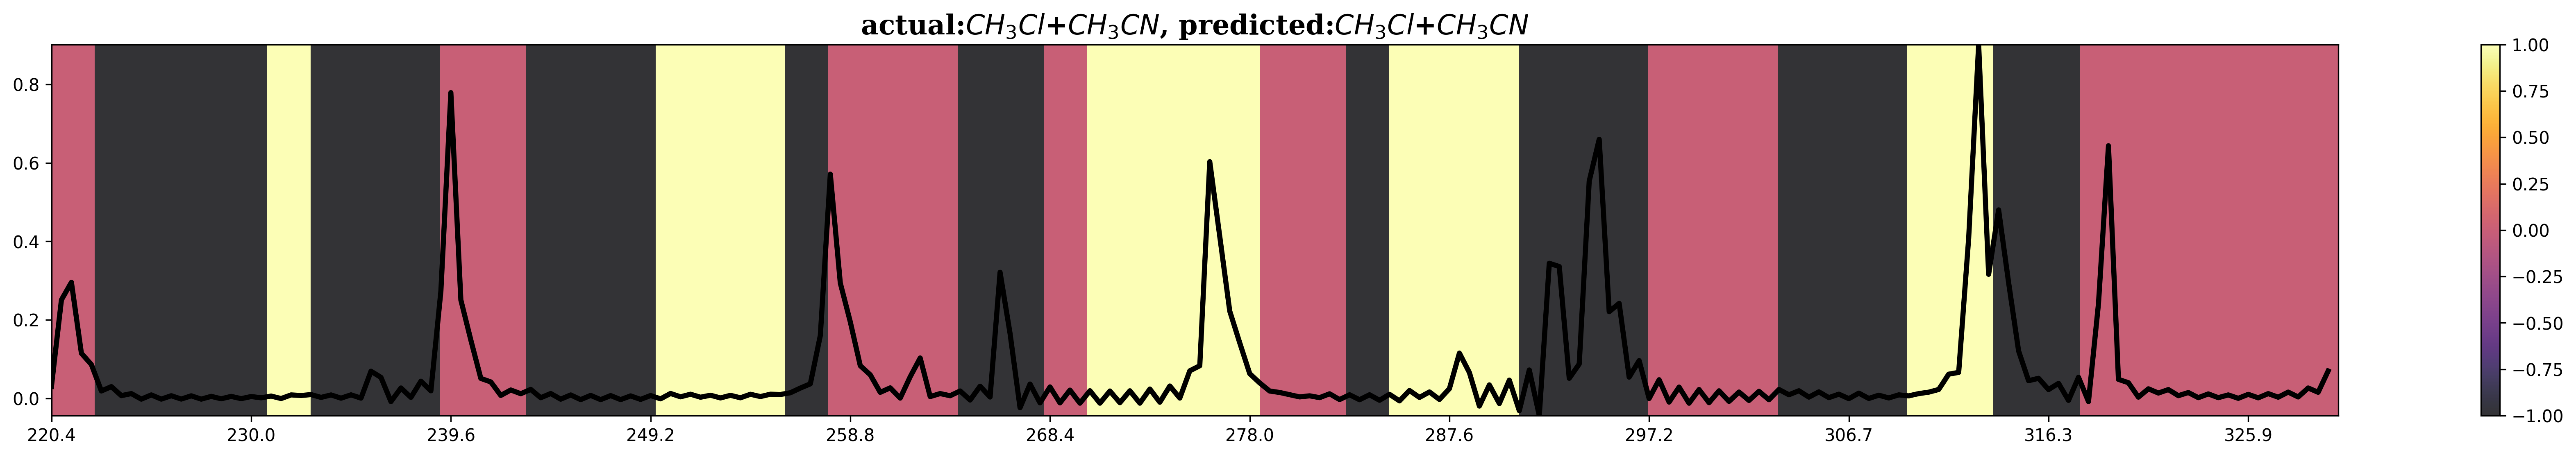

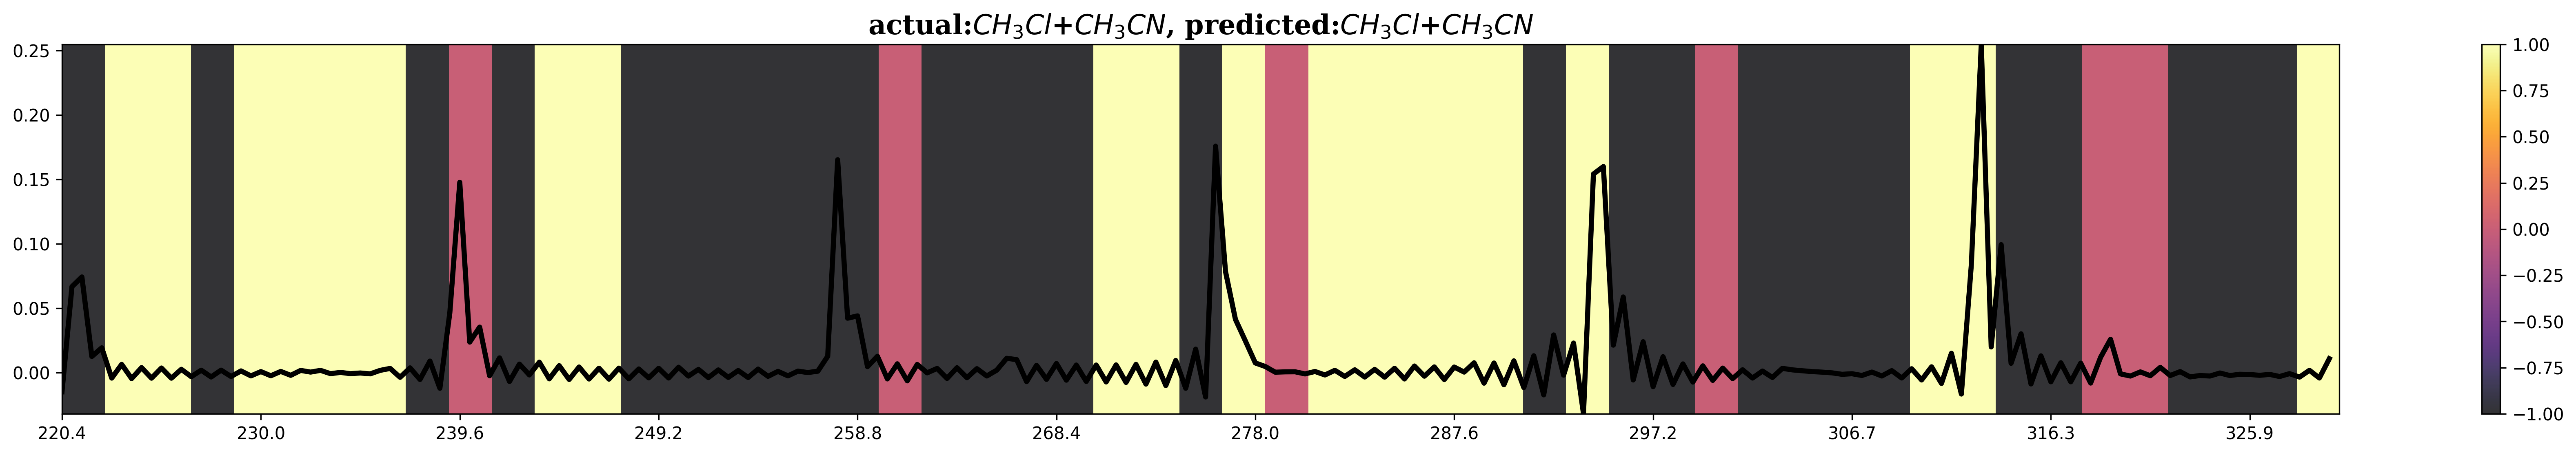

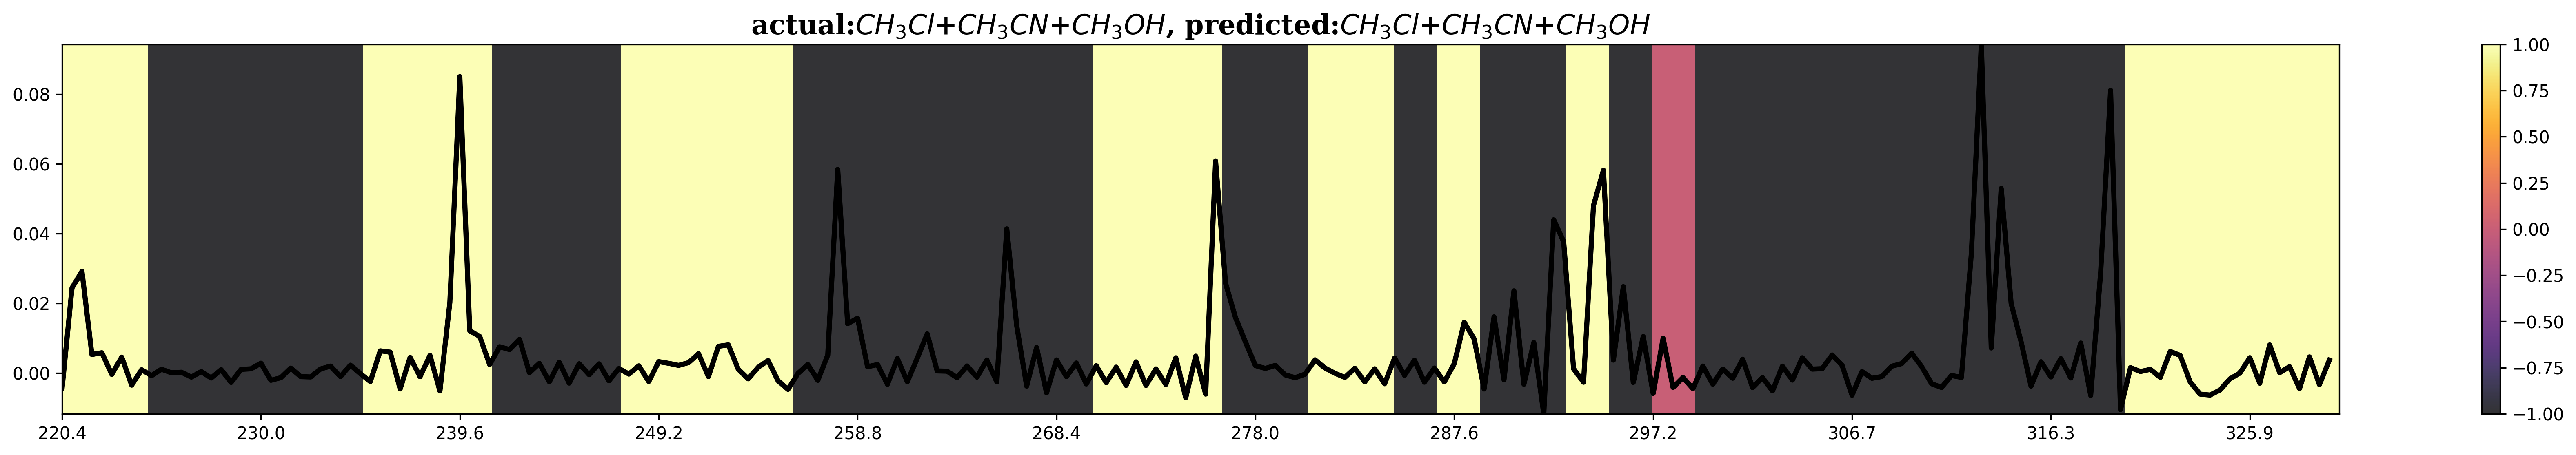

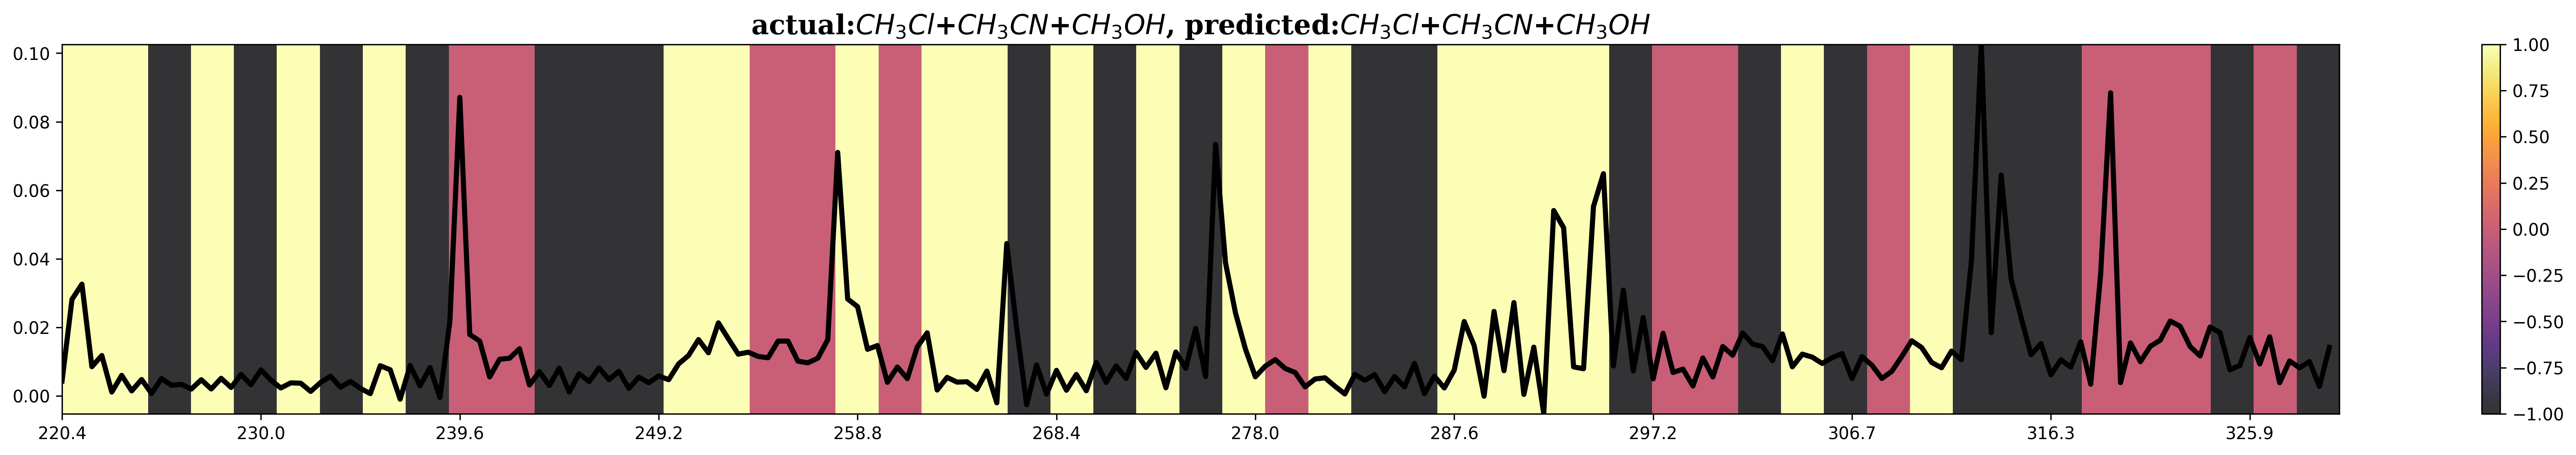

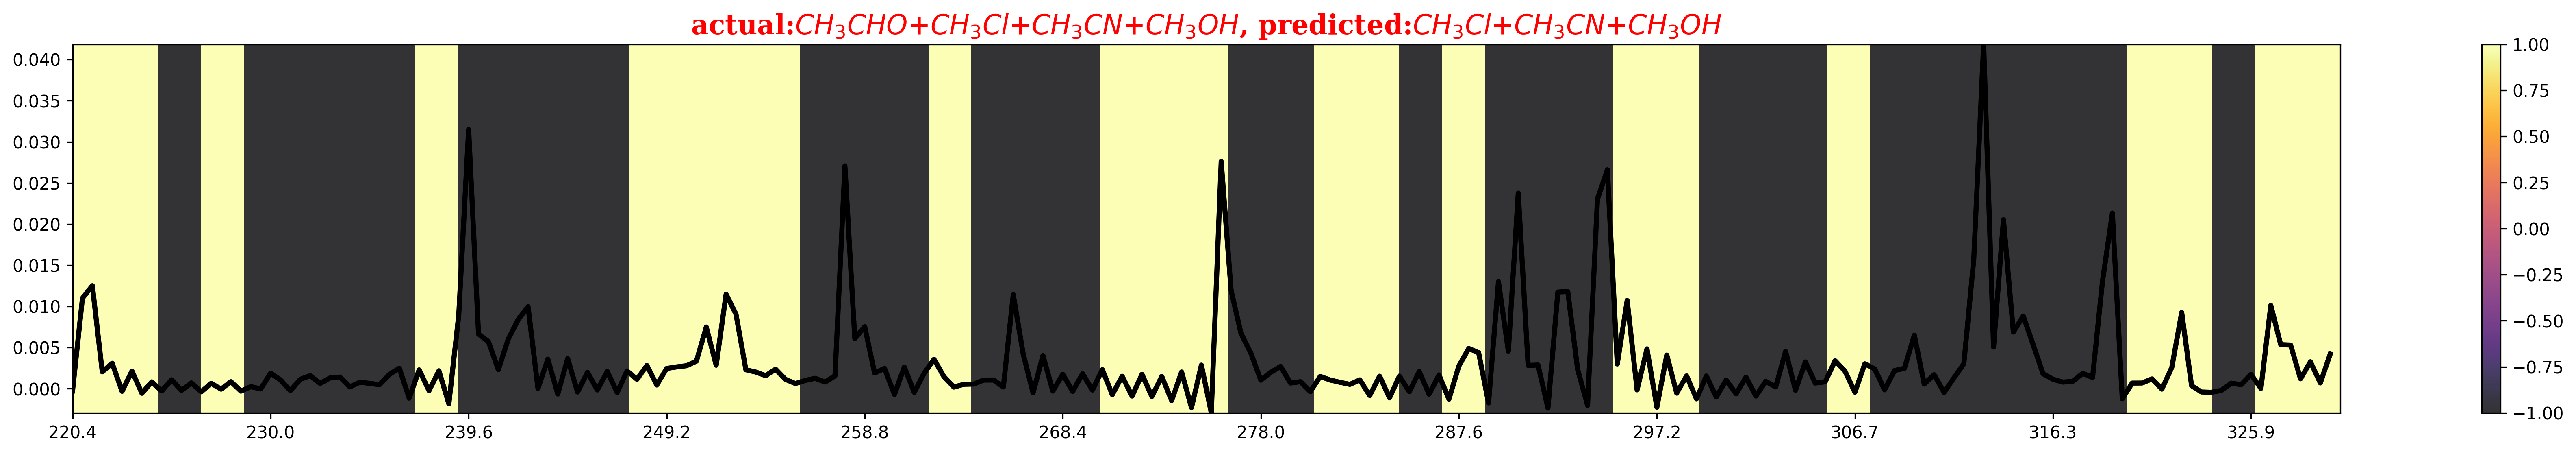

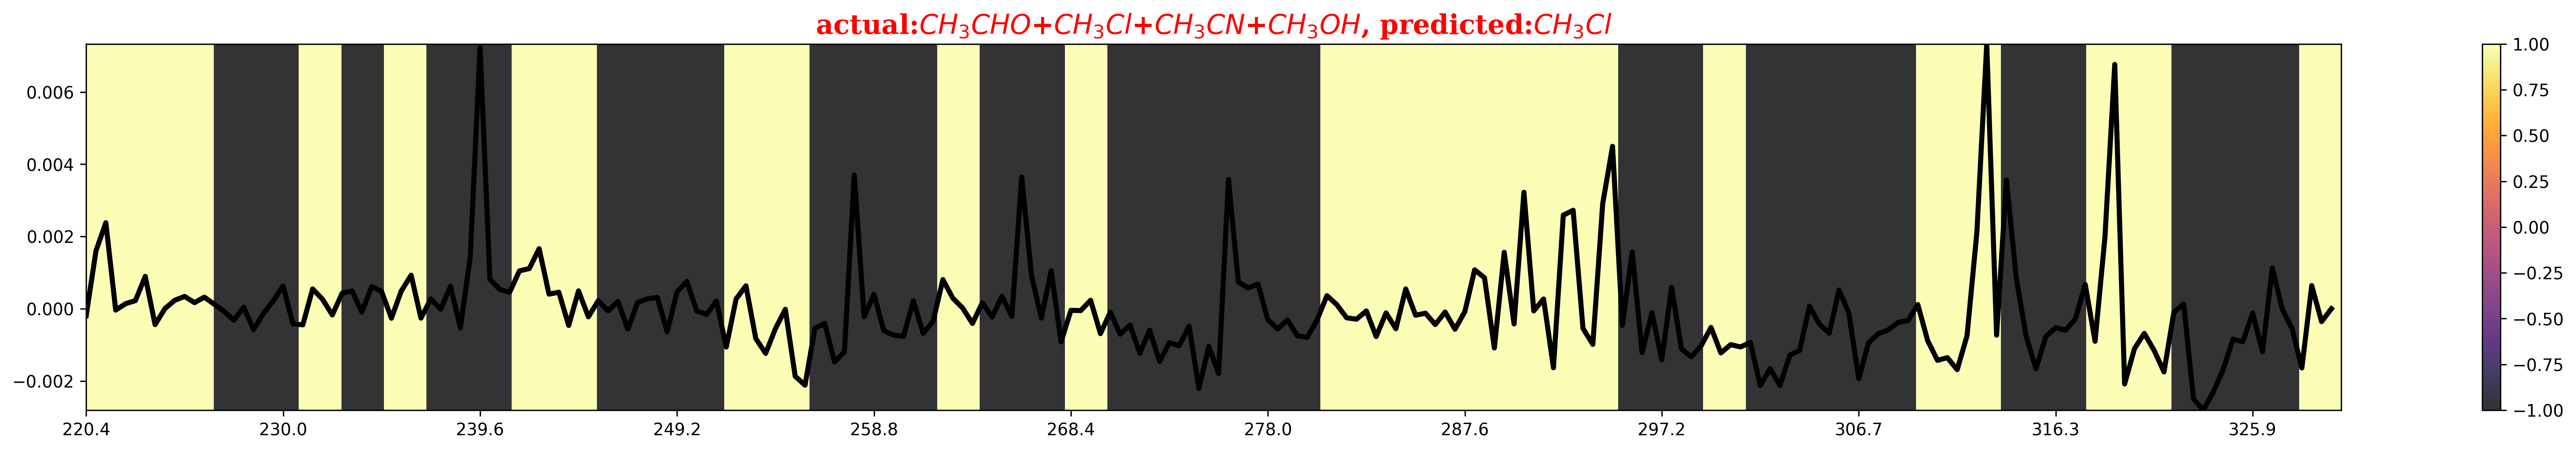

In [61]:
layer_name = 'C5'
#calculate max heatmap value to normalize the plots
# max_heat_map_vals=[]
# min_heat_map_vals=[]
# for i in x_val:
    
#     data = np.expand_dims(i,0)
#     heatmap = grad_cam(layer_name,data, model)
#     max_heat_map_vals.append(np.max(heatmap))
#     min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies

count = 0





for i,j,k in zip(Xexp,yexp,pred_exp):
    
    data = np.expand_dims(i,0)
    heatmap = normalize(grad_cam(layer_name,data, model), axis=0)
#     normalized_hm = [(x-np.min(heatmap[0]))/(np.max(heatmap[0])-np.min(heatmap[0])) for x in heatmap[0]]
#     heatmap = np.expand_dims(normalized_hm,0)
#     import pdb; pdb.set_trace()
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='inferno', aspect="auto", interpolation='nearest', interpolation_stage='rgba',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
#     print(heatmap)
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_exp_C5_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==17:
        break
        
        

In [28]:
df_exp1 = pd.read_excel(exp_path + exps[0])


freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()

#     fft_filter(freq_exp1, abs_exp1, factor=75)

dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
pred_exp_label = np.argmax(model.predict(expanded_abs), axis=-1)[0]

score_predictions = probability_model.predict(expanded_abs)
scoreDf = pd.DataFrame()
scoreDf['mixture_type'] = mixture_types
#     import pdb; pdb.set_trace()
scoreDf['softmax'] = score_predictions[0]
#     scoreDf.to_csv(r'RESULTS/exp_preds/' + 'exp' + str(idx) + '.csv')

sorted_scoresDf = scoreDf.sort_values(by='softmax', ascending=False).head(n=5)

#     print(score_predictions)
print('Experiment name: ',exp_filepath.split('/')[0])
print('File name: ',exp_filepath.split('/')[1])
print('predicted index ', pred_exp_label)
print('predicted label', mixture_types[pred_exp_label])





# idx = 0 
# for experiment in exps:
#     pred_exp_label, sorted_scoresDf = classify_exp(exp_path,experiment,mixture_types, true_label[idx],excel=True)
#     idx+=1
#     sorted_scoresDf.index.name = 'label'


Experiment name:  4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN
File name:  0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx
predicted index  81
predicted label $CH_3Cl$+$CH_3CN$


In [ ]:
layer_name = 'C5'
#calculate max heatmap value to normalize the plots
max_heat_map_vals=[]
min_heat_map_vals=[]
for i in x_val:
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    max_heat_map_vals.append(np.max(heatmap))
    min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies

count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
    
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C5_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==10:
        break
        
        

notebook ends!